# 0 Importación de datos


In [2]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from gluonts.dataset.repository import get_dataset
import os

# --- CONFIGURACIÓN RPY2 PARA WINDOWS ---
# 1. Configurar variables de entorno de R si es necesario (Opcional, ayuda en Windows)
# Si tienes errores de DLL, descomenta y ajusta la ruta a tu instalación de R:
# os.environ['R_HOME'] = r'C:\Program Files\R\R-4.X.X' 

import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter

# Cargar la extensión de magia (esto permite usar %%R)
%load_ext rpy2.ipython

warnings.filterwarnings('ignore')

# NOTA: Eliminamos 'pandas2ri.activate()' porque causaba el error.
# La extensión rpy2.ipython moderna suele manejar la conversión automáticamente.

# Función de graficado interactivo (Estilo Bancolombia)
def plot_(title, *series):
    fig = go.Figure()
    
    # Agregar las series
    for x_variable, y_variable, label in series:
        fig.add_trace(go.Scatter(
            x=x_variable, y=y_variable, mode='lines', name=label, line=dict(width=1.5)
        ))
    
    # Actualización del Layout General
    fig.update_layout(
        title=dict(text=title, x=0.5, xanchor='center'),
        template='plotly_white',
        
        # --- CAMBIO 1: Márgenes ---
        # t=100: Da espacio arriba para que el Título no choque con los botones
        # b=100: Da espacio abajo para la Leyenda
        margin=dict(t=120, b=100), 
        
        # --- CAMBIO 2: Posición de la Leyenda ---
        # La movemos abajo del todo para limpiar la parte superior
        legend=dict(
            orientation="h",     # Horizontal
            yanchor="top",
            y=-0.3,              # Posición negativa (debajo del eje X y slider)
            xanchor="center",
            x=0.5                # Centrada
        )
    )

    # Configuración del Eje X y Botones
    fig.update_xaxes(
        type='date',
        rangeselector=dict(
            # Posición de los botones
            x=0,
            y=1.05,              # Los subimos un poquito más para separarlos de la gráfica
            buttons=list([
                dict(count=24, label="24h", step="hour", stepmode="backward"),
                dict(count=7, label="1w", step="day", stepmode="backward"),
                dict(step="all")
            ])
        ),
        rangeslider=dict(visible=True)
    )

    fig.update_yaxes(autorange=True, title="Valor")

    fig.show()

c:\Users\pleal\Documents\Unal\Tesis\Codigo\Prediccion_Probabilistica\.venv\Lib\site-packages\gluonts\json.py:102: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
Error importing in API mode: ImportError('On Windows, cffi mode "ANY" is only "ABI".')
Trying to import in ABI mode.


In [3]:
%%R
# Instalamos las librerías de R necesarias para el análisis
if (!require("forecast")) install.packages("forecast")
if (!require("astsa")) install.packages("astsa")
if (!require("nonlinearTseries")) install.packages("nonlinearTseries")
if (!require("tidyverse")) install.packages("tidyverse")
if (!require("lubridate")) install.packages("lubridate")
if (!require("tseries")) install.packages("tseries")
if (!require("FinTS")) install.packages("FinTS")
if (!require("changepoint")) install.packages("changepoint")
if (!require("nortest")) install.packages("nortest")
if (!require("strucchange")) install.packages("strucchange")
if (!require("tsDyn")) install.packages("tsDyn")


library(tidyverse)
library(forecast)
library(astsa)
library(nonlinearTseries)
library(tseries)      # ADF, KPSS
library(FinTS)        # ARCH Test
library(forecast)     # MSTL
library(changepoint)  # Structural Breaks
library(nortest)      # Pruebas de normalidad extra
library(ggplot2)      # Gráficos bonitos
library(tsDyn)   # Manejo de fechas

-- Attaching core tidyverse packages ------------------------ tidyverse 2.0.0 --
v dplyr     1.1.4     v readr     2.1.5
v forcats   1.0.0     v stringr   1.5.1
v ggplot2   3.5.1     v tibble    3.2.1
v lubridate 1.9.4     v tidyr     1.3.1
v purrr     1.0.4     
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
i Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


Cargando paquete requerido: forecast
Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
This is forecast 8.24.0 
  Want to stay up-to-date? Read the Hyndsight blog:
  https://robjhyndman.com/hyndsight/
Cargando paquete requerido: astsa

Adjuntando el paquete: 'astsa'

The following object is masked from 'package:forecast':

    gas

Cargando paquete requerido: nonlinearTseries

Adjuntando el paquete: 'nonlinearTseries'

The following object is masked from 'package:grDevices':

    contourLines

Cargando paquete requerido: tidyverse
Cargando paquete requerido: tseries

    'tseries' version: 0.10-58

    'tseries' is a package for time series analysis and computational
    finance.

    See 'library(help="tseries")' for details.

Cargando paquete requerido: FinTS
Cargando paquete requerido: zoo

Adjuntando el paquete: 'zoo'

The following objects are masked from 'package:base':

    as.Date, as.Date.numeric


Adjuntando el paquete: 'FinTS'


In [4]:
# Cargar Dataset Exchange Rate
dataset = get_dataset("exchange_rate")
series_entry = next(iter(dataset.train)) # Tomamos la primera serie (índice 0)

# Recortamos a los últimos 4000 datos para agilizar el análisis visual
# y evitar saturar R
LIMIT = 1825
values = series_entry['target'][-LIMIT:]
start_date = pd.Timestamp(series_entry['start'].to_timestamp())
freq = series_entry['start'].freq

# Crear índice de fechas
timestamps = pd.date_range(
    end=start_date + pd.Timedelta(hours=len(series_entry['target'])), 
    periods=len(series_entry['target']), 
    freq=freq
)[-LIMIT:]

df = pd.DataFrame({'Date': timestamps, 'Consumo': values}) # Usamos 'Consumo' para mantener consistencia con el dataset
df.set_index('Date', inplace=True)

print(f"Dimensiones: {df.shape}")
display(df.head())

plot_('Exchange Rate', (df.index, df["Consumo"], "Consumo"))

Dimensiones: (1825, 1)


,Consumo
Date,
1983-09-13 23:00:00,0.74600
1983-09-14 23:00:00,0.74525
1983-09-15 23:00:00,0.74755
1983-09-16 23:00:00,0.74375
1983-09-19 23:00:00,0.74585


In [5]:
# Reseteamos índice para pasarlo a R limpiamente
df_r = df.reset_index()
# Importante: R maneja fechas mejor como strings ISO o objetos Date
df_r['Date'] = df_r['Date'].dt.strftime('%Y-%m-%d %H:%M:%S')

# CORRECCIÓN DE VALOR: Box-Cox falla con 0.
# Detectamos si hay ceros y calculamos un offset
min_val = df_r['Consumo'].min()
offset = 0
if min_val <= 0:
    offset = abs(min_val) + 1.0
    print(f"⚠️ Se detectaron valores <= 0. Se aplicará un offset de {offset} para análisis Box-Cox.")

df_r['Consumo_Offset'] = df_r['Consumo'] + offset

In [6]:
%%R -i df_r
# Convertimos la columna Date a formato fecha-hora en R
df_r$Date <- as.POSIXct(df_r$Date, format="%Y-%m-%d %H:%M:%S")
head(df_r)

                 Date Consumo Consumo_Offset
0 1983-09-13 23:00:00 0.74600        0.74600
1 1983-09-14 23:00:00 0.74525        0.74525
2 1983-09-15 23:00:00 0.74755        0.74755
3 1983-09-16 23:00:00 0.74375        0.74375
4 1983-09-19 23:00:00 0.74585        0.74585
5 1983-09-20 23:00:00 0.74555        0.74555


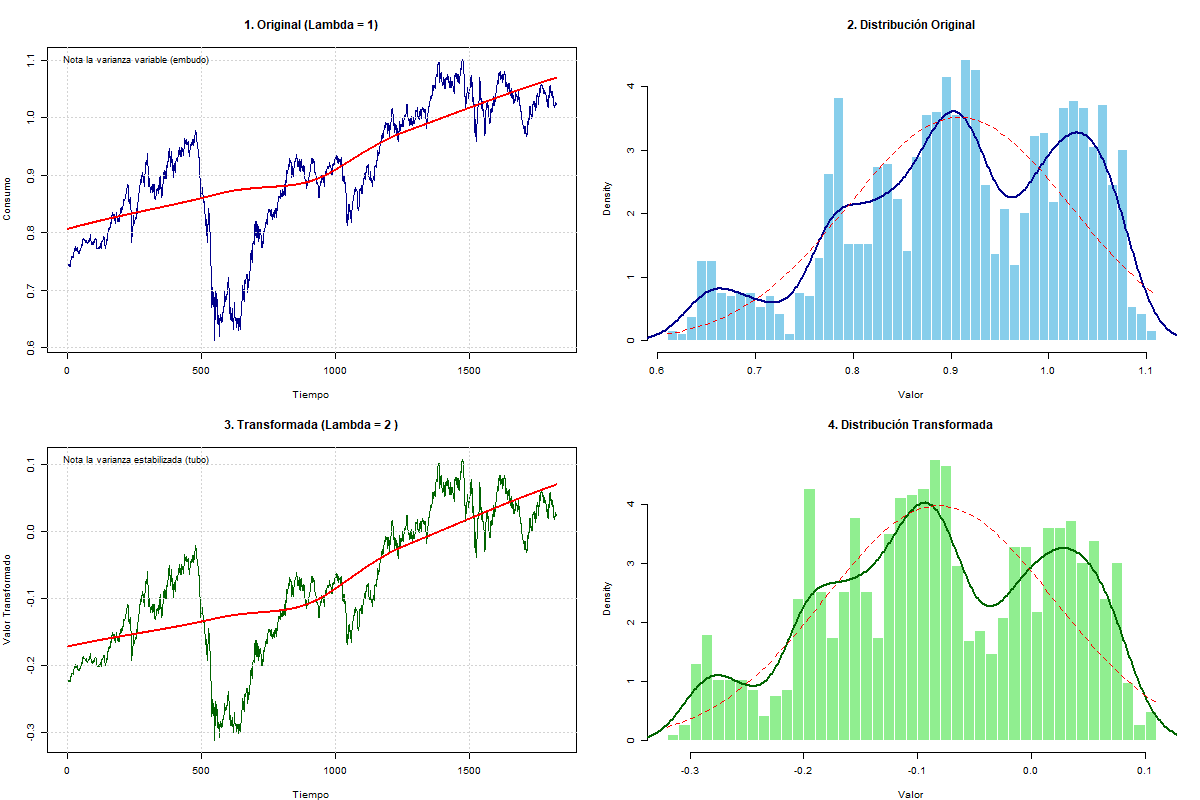

In [7]:
%%R -w 1200 -h 800

# Aseguramos librerías
library(forecast)

# 1. Definimos los datos y calculamos Lambda (Usamos Guerrero por ser series de tiempo)
# Puedes cambiar a method="loglik" si quieres ver el óptimo para normalidad
lambda_opt <- BoxCox.lambda(df_r$Consumo_Offset, method = "guerrero")

# 2. Creamos los datos transformados
data_orig <- df_r$Consumo_Offset
data_trans <- BoxCox(df_r$Consumo_Offset, lambda_opt)

# 3. Configuración del panel de gráficos (2 filas, 2 columnas)
par(mfrow=c(2,2), mar=c(4,4,4,2))

# --- GRÁFICOS ORIGINALES ---

# A. Serie de Tiempo Original
plot(data_orig, type="l", col="darkblue", 
     main=paste("1. Original (Lambda = 1)"),
     ylab="Consumo", xlab="Tiempo")
grid()
# Agregamos una linea de tendencia visual
lines(lowess(data_orig), col="red", lwd=2)
legend("topleft", legend="Nota la varianza variable (embudo)", bty="n", cex=0.9)

# B. Histograma Original
hist(data_orig, breaks=50, col="skyblue", border="white", probability=TRUE,
     main="2. Distribución Original", xlab="Valor")
lines(density(data_orig), col="darkblue", lwd=2)
# Curva normal teórica para comparar
curve(dnorm(x, mean=mean(data_orig), sd=sd(data_orig)), add=TRUE, col="red", lty=2)


# --- GRÁFICOS TRANSFORMADOS ---

# C. Serie de Tiempo Transformada
plot(data_trans, type="l", col="darkgreen", 
     main=paste("3. Transformada (Lambda =", round(lambda_opt, 3), ")"),
     ylab="Valor Transformado", xlab="Tiempo")
grid()
lines(lowess(data_trans), col="red", lwd=2)
legend("topleft", legend="Nota la varianza estabilizada (tubo)", bty="n", cex=0.9)

# D. Histograma Transformado
hist(data_trans, breaks=50, col="lightgreen", border="white", probability=TRUE,
     main="4. Distribución Transformada", xlab="Valor")
lines(density(data_trans), col="darkgreen", lwd=2)
# Curva normal teórica para comparar
curve(dnorm(x, mean=mean(data_trans), sd=sd(data_trans)), add=TRUE, col="red", lty=2)

# Restablecer configuración de gráficos
par(mfrow=c(1,1))

[1] "Lambda estimado: 1.99992424816297"


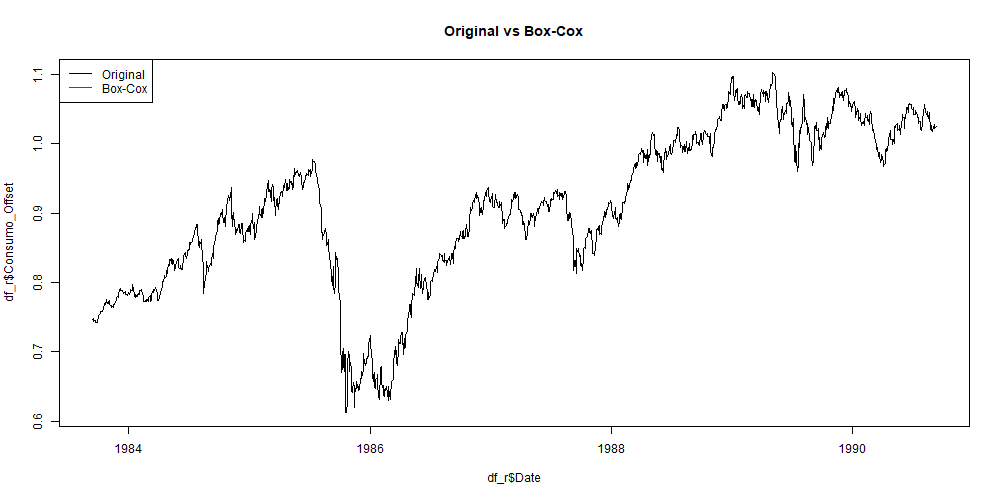

In [8]:
%%R -w 1000 -h 500
# Usamos la columna con Offset para evitar el error "Data must be positive"
# lambda calculation
Lambda_est <- BoxCox.lambda(df_r$Consumo_Offset, method = "guerrero")

print(paste("Lambda estimado:", Lambda_est))

# Graficamos en R
plot(df_r$Date, df_r$Consumo_Offset, type="l", col="black", main="Original vs Box-Cox")
lines(df_r$Date, BoxCox(df_r$Consumo_Offset, Lambda_est), col="red")
legend("topleft", legend=c("Original", "Box-Cox"), col=c("black", "red"), lty=1)

# Guardamos la variable transformada en el dataframe de R
df_r$BoxCox_Consumo <- BoxCox(df_r$Consumo_Offset, Lambda_est)

In [9]:
# Traer la variable transformada de vuelta a Python
df['BoxCox_Consumo'] = %R df_r$BoxCox_Consumo
lambda_r = %R Lambda_est

plot_(f'Estabilización de la Varianza (Box-cox λ ={lambda_r[0]:.3f} )', 
      (df.index, df["Consumo"], "Datos Originales"),
      (df.index, df["BoxCox_Consumo"], "BoxCox Transformado"))

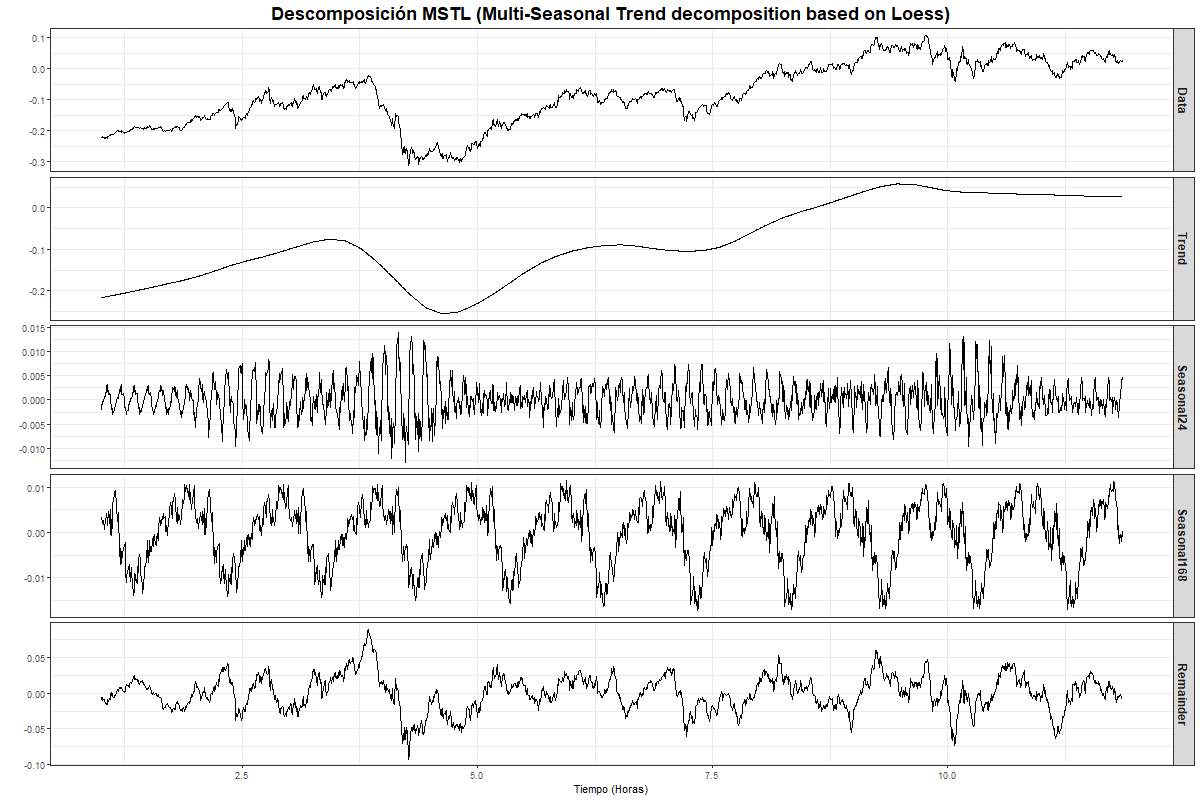

In [10]:
%%R -w 1200 -h 800

# Usamos la serie BoxCox (con estacionalidad) para descomponerla
# Definimos los periodos: 24 (diario) y 168 (semanal)
y_msts <- msts(df_r$BoxCox_Consumo, seasonal.periods=c(24, 168))

# Ajustamos descomposición MSTL
fit_mstl <- mstl(y_msts)

# Graficamos
autoplot(fit_mstl) + 
  ggtitle("Descomposición MSTL (Multi-Seasonal Trend decomposition based on Loess)") +
  xlab("Tiempo (Horas)") +
  theme_bw() +
  theme(plot.title = element_text(size=18, face="bold", hjust=0.5),
        strip.text = element_text(size=12, face="bold"))

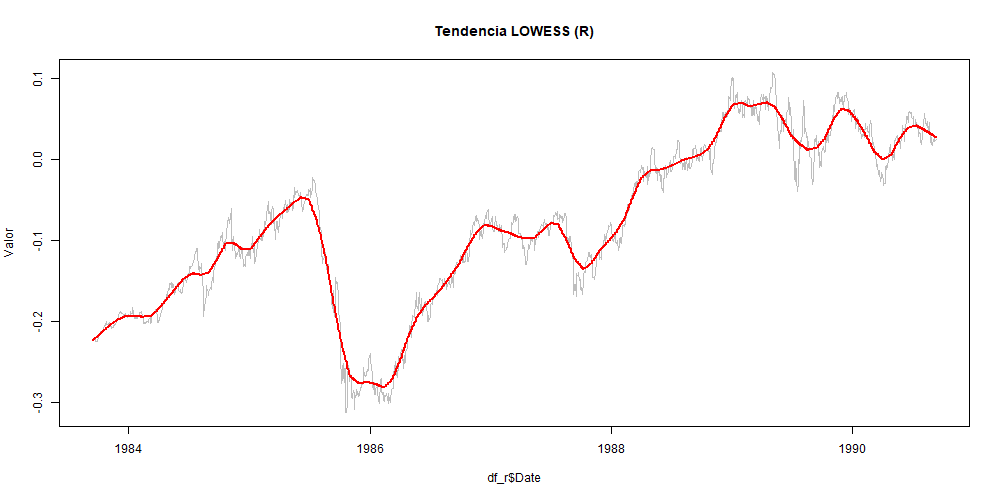

In [11]:
%%R -w 1000 -h 500
# Calcular LOWESS sobre la data transformada
# f = suavizado. Para datos horarios (4000 pts), usamos un f pequeño
trend_lowess_R <- lowess(df_r$BoxCox_Consumo, f = 0.05, iter = 0)

# Extraer tendencia y residuo
df_r$Trend <- trend_lowess_R$y
df_r$Trend_Removed <- df_r$BoxCox_Consumo - df_r$Trend

# Gráfico R estilo base
plot(df_r$Date, df_r$BoxCox_Consumo, type='l', col='gray', main='Tendencia LOWESS (R)', ylab='Valor')
lines(df_r$Date, df_r$Trend, col='red', lwd=2)

In [12]:
# Traemos las columnas calculadas en R
df['Trend'] = %R df_r$Trend
df['Trend_Removed'] = %R df_r$Trend_Removed

plot_('Eliminación de Tendencia por Lowess', 
      (df.index, df["BoxCox_Consumo"], "BoxCox"),
      (df.index, df["Trend"], "Tendencia Suavizada"),
      (df.index, df["Trend_Removed"], "Sin Tendencia (Residuo)"))

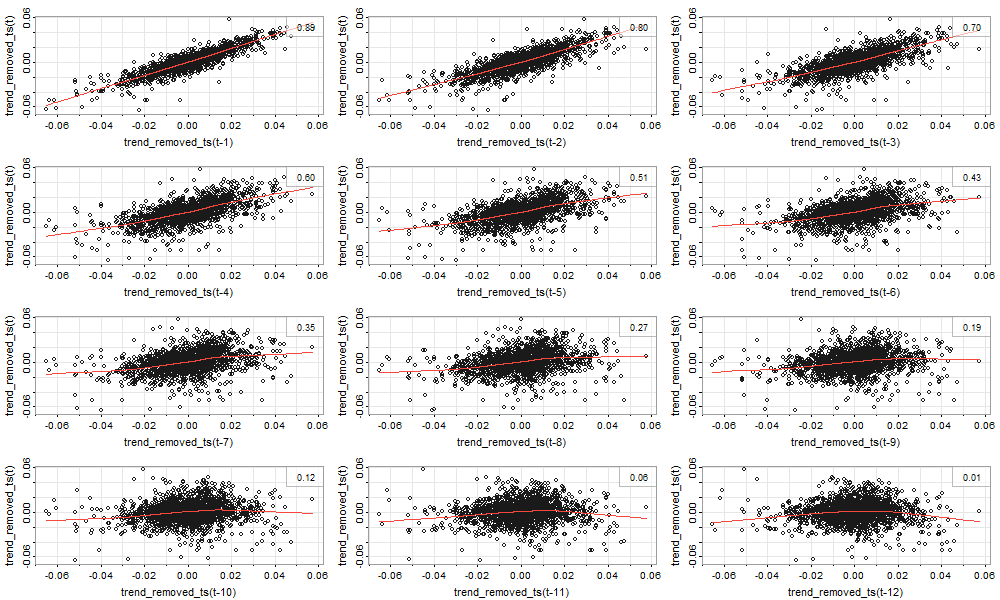

In [13]:
%%R -w 1000 -h 600
# Pasamos la serie sin tendencia a un objeto ts (time series)
# Frecuencia 24 porque son datos horarios
trend_removed_ts <- ts(df_r$Trend_Removed, frequency = 24)

options(repr.plot.width=20, repr.plot.height=6)
library(astsa)

# Graficamos los primeros 12 lags con correlación y línea lowess
astsa::lag1.plot(trend_removed_ts, 12)

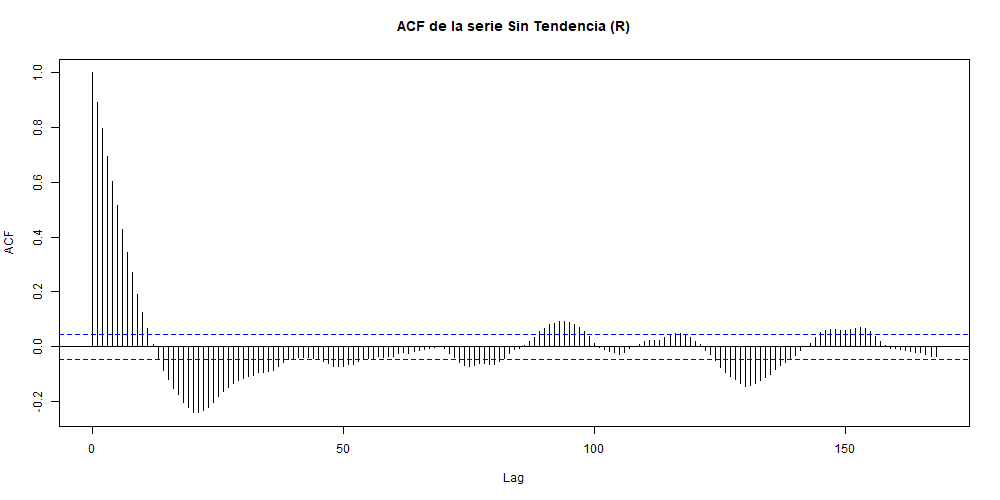

In [14]:
%%R -w 1000 -h 500
# ACF con un lag.max amplio para ver ciclos diarios (24) y semanales (168)
acf(df_r$Trend_Removed, lag.max = 168, main = "ACF de la serie Sin Tendencia (R)")

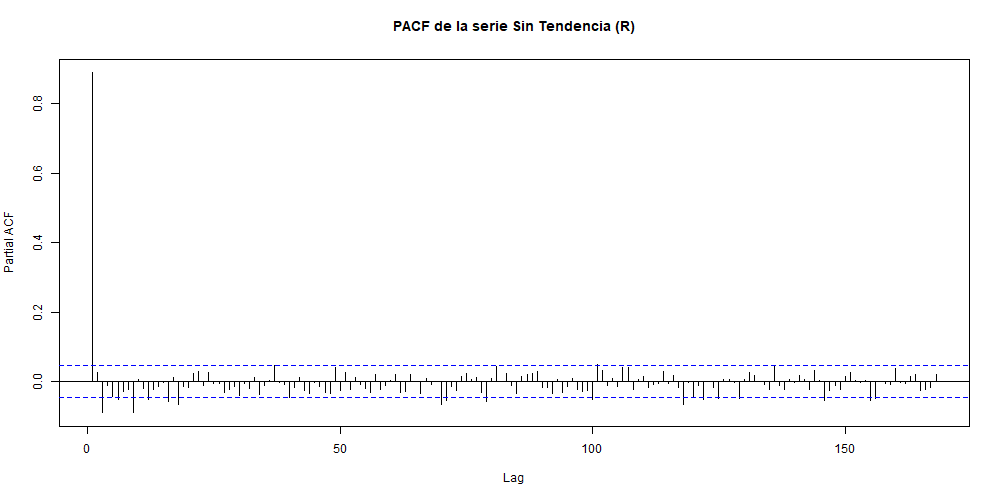

In [15]:
%%R -w 1000 -h 500
# PACF con un lag.max amplio para ver ciclos diarios (24) y semanales (168)
pacf(df_r$Trend_Removed, lag.max = 168, main = "PACF de la serie Sin Tendencia (R)")

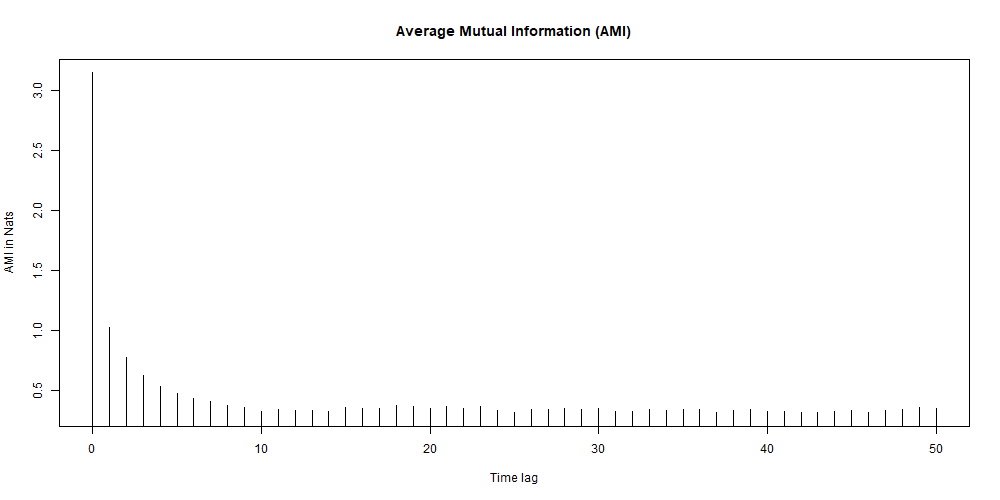

In [16]:
%%R -w 1000 -h 500
library(nonlinearTseries)
# Información mutua para detectar dependencias no lineales
mi <- mutualInformation(df_r$Trend_Removed, lag.max = 50, n.partitions = 50, 
                        units = "Nats", do.plot = TRUE, main="Información Mutua (R)")

In [17]:
%%R
# Función auxiliar para interpretar p-values limpiamente
interpret_p <- function(p_val, alpha=0.05, h0_desc, h1_desc) {
    res <- ifelse(p_val < alpha, h1_desc, h0_desc)
    signif <- ifelse(p_val < 0.001, "***", ifelse(p_val < 0.01, "**", ifelse(p_val < 0.05, "*", "ns")))
    cat(sprintf("   -> p-value: %.5f (%s) \n   -> Conclusión: %s\n", p_val, signif, res))
}


 1. PRUEBAS DE ESTACIONARIEDAD (Unit Root Tests)

[A] Augmented Dickey-Fuller Test (ADF)
    H0: La serie TIENE raiz unitaria (No estacionaria)
   -> p-value: 0.01000 (*) 
   -> Conclusion: [OK] Estacionaria

[B] KPSS Test
    H0: La serie ES estacionaria alrededor de tendencia
   -> p-value: 0.10000 (ns) 
   -> Conclusion: [OK] Estacionaria

NOTA: Buscamos 'OK' en ambas pruebas.


In addition: Warning messages:
1: In adf.test(serie_analisis) : p-value smaller than printed p-value
2: In kpss.test(serie_analisis, null = "Level") :
  p-value greater than printed p-value


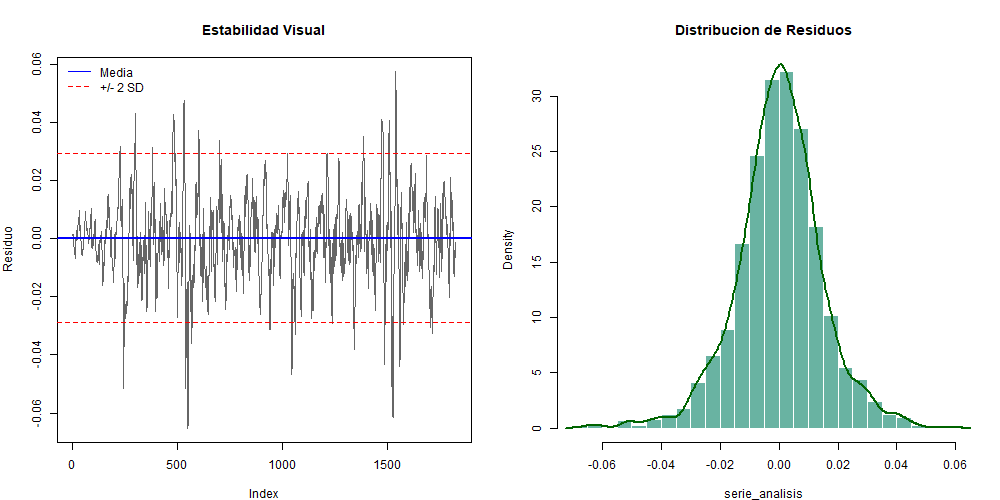

In [18]:
%%R -w 1000 -h 500

par(mfrow=c(1,2), mar=c(4,4,4,2))

# Datos a analizar
serie_analisis <- na.omit(df_r$Trend_Removed)

# 1. Grafico de la serie
plot(serie_analisis, type='l', col='gray40', main="Estabilidad Visual", ylab="Residuo")
abline(h=mean(serie_analisis), col="blue", lwd=2)
abline(h=mean(serie_analisis) + 2*sd(serie_analisis), col="red", lty=2)
abline(h=mean(serie_analisis) - 2*sd(serie_analisis), col="red", lty=2)
legend("topleft", legend=c("Media", "+/- 2 SD"), col=c("blue", "red"), lty=c(1,2), bty="n")

# 2. Histograma
hist(serie_analisis, breaks=40, col="#69b3a2", border="white", main="Distribucion de Residuos", probability=TRUE)
lines(density(serie_analisis), col="darkgreen", lwd=2)

# --- FUNCION AUXILIAR LIMPIA (SIN TILDES) ---
interpret_p <- function(p_val, alpha=0.05, h0_desc, h1_desc) {
    # Seleccionamos el mensaje basado en el p-value
    res <- ifelse(p_val < alpha, h1_desc, h0_desc)
    
    # Marcas de significancia visuales (ASCII)
    signif <- ifelse(p_val < 0.001, "***", ifelse(p_val < 0.01, "**", ifelse(p_val < 0.05, "*", "ns")))
    
    # Usamos cat sin caracteres especiales
    cat(sprintf("   -> p-value: %.5f (%s) \n   -> Conclusion: %s\n", p_val, signif, res))
}

# --- REPORTES DE TEXTO ---
cat("\n=======================================================\n")
cat(" 1. PRUEBAS DE ESTACIONARIEDAD (Unit Root Tests)\n")
cat("=======================================================\n")

# A. ADF Test
cat("\n[A] Augmented Dickey-Fuller Test (ADF)\n")
cat("    H0: La serie TIENE raiz unitaria (No estacionaria)\n")
test_adf <- adf.test(serie_analisis)
interpret_p(test_adf$p.value, h0_desc="[FALLO] No Estacionaria", h1_desc="[OK] Estacionaria")

# B. KPSS Test
cat("\n[B] KPSS Test\n")
cat("    H0: La serie ES estacionaria alrededor de tendencia\n")
test_kpss <- kpss.test(serie_analisis, null="Level")
interpret_p(test_kpss$p.value, h0_desc="[OK] Estacionaria", h1_desc="[FALLO] No Estacionaria")

cat("\nNOTA: Buscamos 'OK' en ambas pruebas.\n")

   BATERÍA DE TESTS DE NO LINEALIDAD (Python)

----------------------------------------------------------------------
 [1] TEST BDS (Aproximación)
----------------------------------------------------------------------
  Estadístico Z: 4.4274
  p-value: 0.000010 ***
  ✓ Fuerte evidencia de dependencia no lineal

----------------------------------------------------------------------
 [2] TEST McLEOD-LI (Ljung-Box en Residuos²)
----------------------------------------------------------------------
  Estadístico LB: 3255.9376
  p-value: 0.000000 ***
  ✓ Fuerte evidencia de efectos ARCH/GARCH
  → Recomendación: Usar modelos con varianza condicional

----------------------------------------------------------------------
 [3] TEST DE TSAY (No linealidad en estructura)
----------------------------------------------------------------------
  Estadístico F: 0.3295
  R² (no lineal): 0.0016
  p-value: 0.965520 (ns)
  ✗ Estructura lineal dominante

--------------------------------------------------

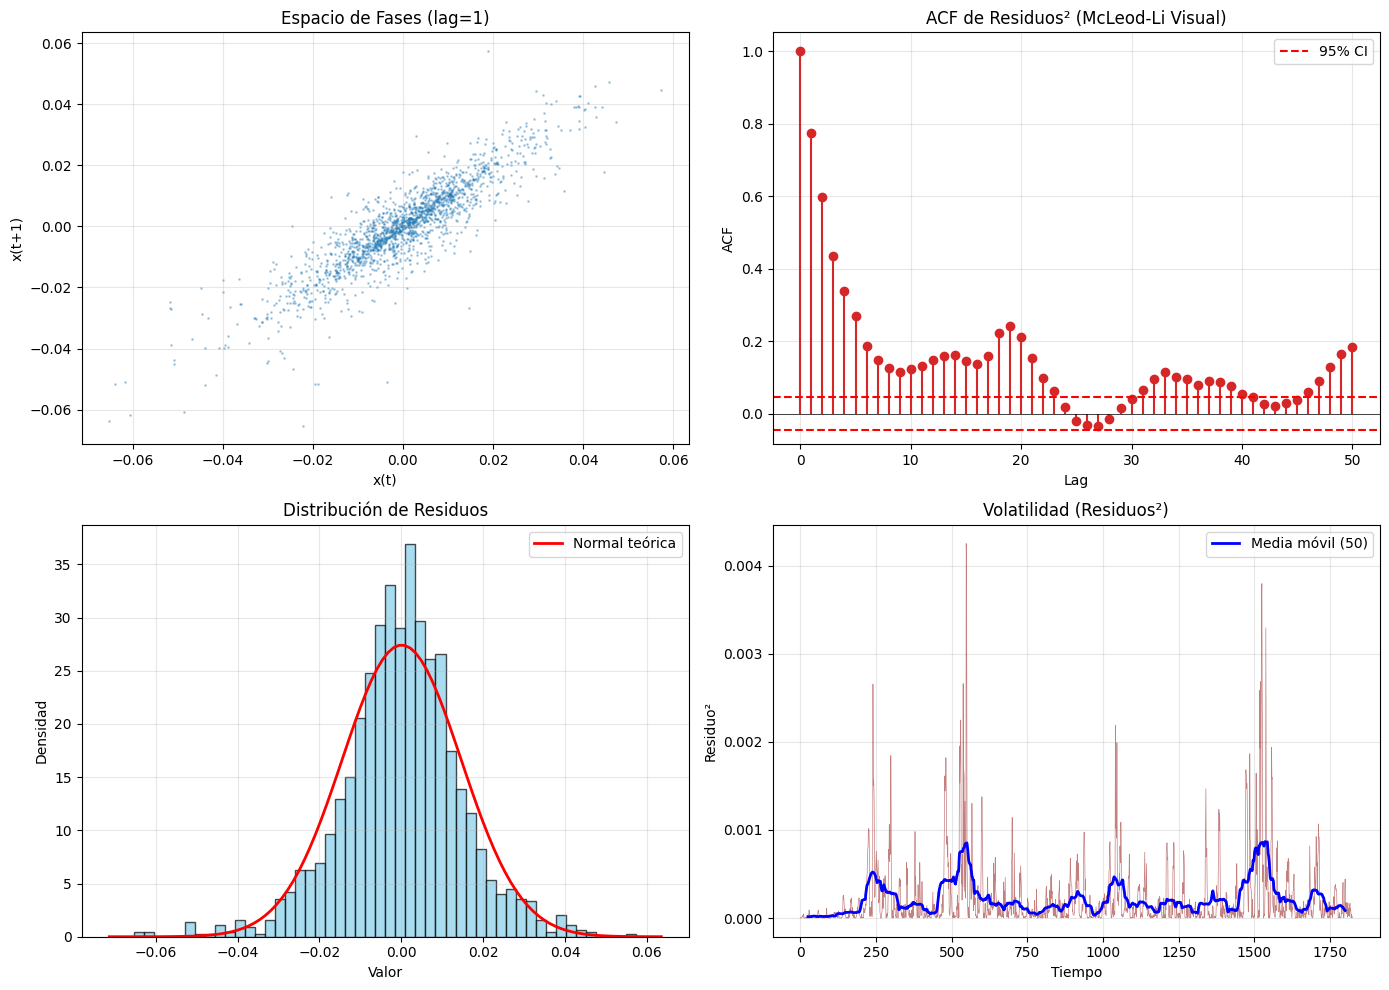


   RESUMEN Y RECOMENDACIONES PARA TU TESIS

Estos tests te permiten justificar:

1. BDS rechaza → Dependencia compleja detectada
   → Justifica el uso de LSTM/GRU/Transformer sobre ARMA

2. McLeod-Li rechaza → Varianza condicional presente
   → Usar predicción probabilística (quantiles) es ESENCIAL
   → CRPS es mejor métrica que MSE

3. Tsay rechaza linealidad → Estructura no lineal
   → Modelos lineales (ARMA/ETS) tendrán desempeño limitado

4. H > 0.5 → Memoria larga
   → Considerar horizontes de predicción largos
   → Efectos de largo plazo son importantes



In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.tsa.stattools import acf
from statsmodels.stats.diagnostic import acorr_ljungbox
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# TESTS DE NO LINEALIDAD EN PYTHON (ALTERNATIVA ROBUSTA)
# ============================================================================

def bds_test_python(series, m=2, epsilon=None):
    """
    Test BDS simplificado (aproximación)
    m: embedding dimension
    epsilon: radio (si es None, usa 0.5 * std)
    """
    series = np.array(series)
    n = len(series)
    
    if epsilon is None:
        epsilon = 0.5 * np.std(series)
    
    # Calcular correlación integral
    def correlation_integral(data, eps, m):
        N = len(data) - m + 1
        vectors = np.array([data[i:i+m] for i in range(N)])
        
        count = 0
        for i in range(N):
            for j in range(i+1, N):
                if np.max(np.abs(vectors[i] - vectors[j])) < eps:
                    count += 1
        
        C_m = 2 * count / (N * (N - 1))
        return C_m if C_m > 0 else 1e-10
    
    # Calcular para diferentes dimensiones
    C_1 = correlation_integral(series, epsilon, 1)
    C_m = correlation_integral(series, epsilon, m)
    
    # Estadístico BDS aproximado
    V_mn = n * (C_m - C_1**m)
    
    # Varianza aproximada (simplificada)
    sigma = np. sqrt(4 * (C_1**(2*m) + 2*sum([C_1**(2*k) for k in range(1,m)])))
    
    if sigma > 0:
        z_stat = V_mn / (sigma * np.sqrt(n))
    else:
        z_stat = 0
    
    # P-value usando distribución normal
    p_value = 2 * (1 - stats.norm.cdf(abs(z_stat)))
    
    return z_stat, p_value

def mcleod_li_test(series, lags=24):
    """
    Test de McLeod-Li para dependencia no lineal
    (Ljung-Box en residuos al cuadrado)
    """
    # Centrar la serie
    residuals = series - np.mean(series)
    
    # Test en residuos al cuadrado
    squared_resid = residuals ** 2
    
    # Ljung-Box
    lb_result = acorr_ljungbox(squared_resid, lags=[lags], return_df=True)
    
    return lb_result

def tsay_test(series, lag=1, order=2):
    """
    Test de Tsay para no linealidad
    Basado en regresión de residuos al cuadrado
    """
    from sklearn.linear_model import LinearRegression
    
    n = len(series)
    X = []
    y = []
    
    for i in range(lag * order, n):
        features = []
        for j in range(1, order + 1):
            features.append(series[i - j * lag])
        X.append(features)
        y.append(series[i])
    
    X = np.array(X)
    y = np.array(y)
    
    # Regresión lineal
    model = LinearRegression()
    model.fit(X, y)
    residuals = y - model.predict(X)
    
    # Construir características no lineales (cuadrados y productos cruzados)
    X_nonlinear = []
    for i in range(len(X)):
        row = list(X[i])
        # Agregar cuadrados
        row.extend([x**2 for x in X[i]])
        # Agregar productos cruzados
        for j in range(len(X[i])):
            for k in range(j+1, len(X[i])):
                row.append(X[i][j] * X[i][k])
        X_nonlinear.append(row)
    
    X_nonlinear = np.array(X_nonlinear)
    
    # Regresión de residuos² contra términos no lineales
    from sklearn.linear_model import Ridge
    model_nl = Ridge(alpha=1.0)
    model_nl.fit(X_nonlinear, residuals**2)
    
    # R² como medida de no linealidad
    r2 = model_nl.score(X_nonlinear, residuals**2)
    
    # Test F aproximado
    n_samples = len(residuals)
    k = X_nonlinear.shape[1]
    
    if r2 < 1:
        f_stat = (r2 / k) / ((1 - r2) / (n_samples - k - 1))
        p_value = 1 - stats.f.cdf(f_stat, k, n_samples - k - 1)
    else:
        f_stat = np.inf
        p_value = 0
    
    return f_stat, p_value, r2

def hurst_exponent(series, max_lag=20):
    """
    Exponente de Hurst para detectar memoria larga
    H > 0.5: Persistencia (tendencias)
    H = 0.5: Random walk
    H < 0.5: Anti-persistencia (reversión a la media)
    """
    lags = range(2, max_lag)
    tau = []
    
    for lag in lags:
        # Dividir serie en subseries de tamaño lag
        n_subseries = len(series) // lag
        subseries = [series[i*lag:(i+1)*lag] for i in range(n_subseries)]
        
        # Calcular R/S para cada subserie
        rs_values = []
        for sub in subseries:
            if len(sub) == 0:
                continue
            mean_sub = np.mean(sub)
            cumdev = np.cumsum(sub - mean_sub)
            R = np.max(cumdev) - np.min(cumdev)
            S = np.std(sub)
            if S > 0:
                rs_values.append(R / S)
        
        if rs_values:
            tau.append(np.mean(rs_values))
        else:
            tau.append(np.nan)
    
    # Regresión log-log
    tau = np.array(tau)
    lags = np.array(list(lags))
    
    # Eliminar NaNs
    valid = ~np.isnan(tau) & (tau > 0)
    if sum(valid) < 2:
        return np.nan
    
    log_lags = np.log(lags[valid])
    log_tau = np.log(tau[valid])
    
    # Regresión lineal
    slope, intercept = np.polyfit(log_lags, log_tau, 1)
    
    return slope  # Este es H

# ============================================================================
# EJECUCIÓN DE LOS TESTS
# ============================================================================

# Preparar datos
serie = df['Trend_Removed'].dropna().values

print("="*70)
print("   BATERÍA DE TESTS DE NO LINEALIDAD (Python)")
print("="*70)
print()

# 1. Test BDS
print("-" * 70)
print(" [1] TEST BDS (Aproximación)")
print("-" * 70)
z_stat, p_val = bds_test_python(serie, m=2)
print(f"  Estadístico Z: {z_stat:.4f}")
print(f"  p-value: {p_val:.6f}", end="")

if p_val < 0.001:
    print(" ***")
    print("  ✓ Fuerte evidencia de dependencia no lineal")
elif p_val < 0.05:
    print(" *")
    print("  ✓ Evidencia de dependencia no lineal")
else:
    print(" (ns)")
    print("  ✗ No hay evidencia clara")
print()

# 2. Test McLeod-Li
print("-" * 70)
print(" [2] TEST McLEOD-LI (Ljung-Box en Residuos²)")
print("-" * 70)
ml_result = mcleod_li_test(serie, lags=24)
lb_stat = ml_result['lb_stat'].values[0]
lb_pval = ml_result['lb_pvalue'].values[0]

print(f"  Estadístico LB: {lb_stat:.4f}")
print(f"  p-value: {lb_pval:.6f}", end="")

if lb_pval < 0.001:
    print(" ***")
    print("  ✓ Fuerte evidencia de efectos ARCH/GARCH")
    print("  → Recomendación: Usar modelos con varianza condicional")
elif lb_pval < 0.05:
    print(" *")
    print("  ✓ Evidencia de heterocedasticidad condicional")
else:
    print(" (ns)")
    print("  ✗ Varianza relativamente estable")
print()

# 3. Test de Tsay
print("-" * 70)
print(" [3] TEST DE TSAY (No linealidad en estructura)")
print("-" * 70)
f_stat, p_val, r2 = tsay_test(serie, lag=1, order=3)
print(f"  Estadístico F: {f_stat:.4f}")
print(f"  R² (no lineal): {r2:.4f}")
print(f"  p-value: {p_val:.6f}", end="")

if p_val < 0.001:
    print(" ***")
    print("  ✓ Fuerte no linealidad detectada")
    print("  → Modelos lineales serán insuficientes")
elif p_val < 0.05:
    print(" *")
    print("  ✓ No linealidad presente")
else:
    print(" (ns)")
    print("  ✗ Estructura lineal dominante")
print()

# 4. Exponente de Hurst
print("-" * 70)
print(" [4] EXPONENTE DE HURST (Memoria Larga)")
print("-" * 70)
H = hurst_exponent(serie, max_lag=50)
print(f"  H = {H:.4f}")
print()
print("  Interpretación:")
if H > 0.55:
    print(f"  → Persistencia (H > 0.5): Tendencias se mantienen")
    print(f"  → Memoria larga detectada")
elif H < 0.45:
    print(f"  → Anti-persistencia (H < 0.5): Reversión a la media")
else:
    print(f"  → Random walk (H ≈ 0.5): Sin memoria significativa")
print()

# ============================================================================
# VISUALIZACIONES
# ============================================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Espacio de Fases
ax1 = axes[0, 0]
lag = 1
ax1.scatter(serie[:-lag], serie[lag:], alpha=0.3, s=1)
ax1.set_xlabel('x(t)')
ax1.set_ylabel(f'x(t+{lag})')
ax1.set_title('Espacio de Fases (lag=1)')
ax1.grid(alpha=0.3)

# 2. ACF de Residuos²
ax2 = axes[0, 1]
squared_acf = acf(serie**2, nlags=50)
ax2.stem(squared_acf, linefmt='C3-', markerfmt='C3o', basefmt=' ')
ax2.axhline(y=0, color='k', linestyle='-', linewidth=0.5)
ax2.axhline(y=1.96/np.sqrt(len(serie)), color='r', linestyle='--', label='95% CI')
ax2.axhline(y=-1.96/np.sqrt(len(serie)), color='r', linestyle='--')
ax2.set_title('ACF de Residuos² (McLeod-Li Visual)')
ax2.set_xlabel('Lag')
ax2.set_ylabel('ACF')
ax2.legend()
ax2.grid(alpha=0.3)

# 3. Distribución vs Normal
ax3 = axes[1, 0]
ax3.hist(serie, bins=50, density=True, alpha=0.7, color='skyblue', edgecolor='black')
from scipy.stats import norm
xmin, xmax = ax3.get_xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, np.mean(serie), np.std(serie))
ax3.plot(x, p, 'r-', linewidth=2, label='Normal teórica')
ax3.set_title('Distribución de Residuos')
ax3.set_xlabel('Valor')
ax3.set_ylabel('Densidad')
ax3.legend()
ax3.grid(alpha=0.3)

# 4. Volatilidad (serie²)
ax4 = axes[1, 1]
ax4.plot(serie**2, color='darkred', alpha=0.5, linewidth=0.5)
# Suavizado
window = 50
smoothed = pd.Series(serie**2).rolling(window=window, center=True).mean()
ax4.plot(smoothed, color='blue', linewidth=2, label=f'Media móvil ({window})')
ax4.set_title('Volatilidad (Residuos²)')
ax4.set_xlabel('Tiempo')
ax4.set_ylabel('Residuo²')
ax4.legend()
ax4.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('Analisis_No_Linealidad.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================================================
# RESUMEN EJECUTIVO
# ============================================================================

print()
print("="*70)
print("   RESUMEN Y RECOMENDACIONES PARA TU TESIS")
print("="*70)
print()
print("Estos tests te permiten justificar:")
print()
print("1. BDS rechaza → Dependencia compleja detectada")
print("   → Justifica el uso de LSTM/GRU/Transformer sobre ARMA")
print()
print("2. McLeod-Li rechaza → Varianza condicional presente")
print("   → Usar predicción probabilística (quantiles) es ESENCIAL")
print("   → CRPS es mejor métrica que MSE")
print()
print("3. Tsay rechaza linealidad → Estructura no lineal")
print("   → Modelos lineales (ARMA/ETS) tendrán desempeño limitado")
print()
print("4. H > 0.5 → Memoria larga")
print("   → Considerar horizontes de predicción largos")
print("   → Efectos de largo plazo son importantes")
print()
print("="*70)


 3. PRUEBA DE HETEROCEDASTICIDAD (Efectos ARCH)

[A] ARCH-LM Test (Lagrange Multiplier)
    H0: No hay efectos ARCH (Varianza constante)
   -> p-value: 0.00000 (***) 
   -> Conclusion: Heterocedastico (Hay efectos ARCH)

>>> RECOMENDACION: Considerar modelos GARCH o metodos que manejen varianza variable.


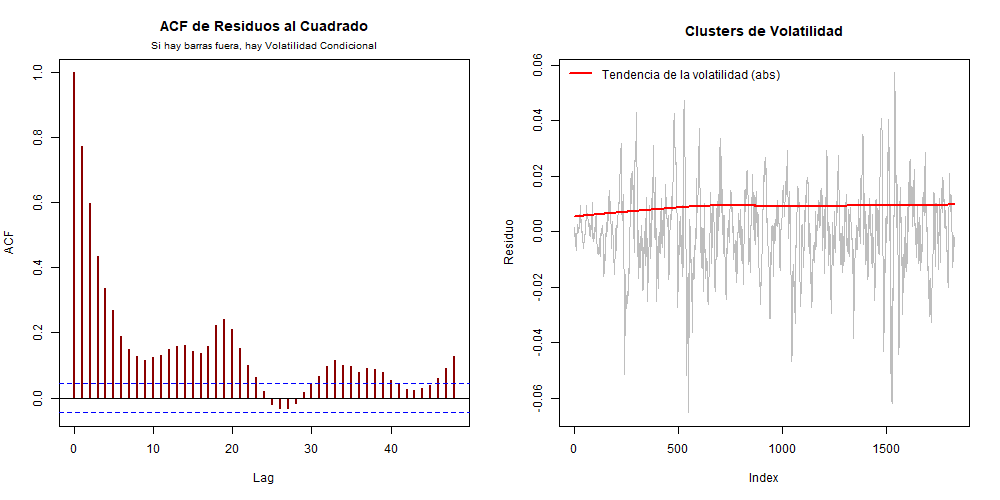

In [20]:
%%R -w 1000 -h 500

serie_residuos <- na.omit(df_r$Trend_Removed)

par(mfrow=c(1,2))

# 1. ACF de los residuos al cuadrado (Proxy visual de heterocedasticidad)
acf(serie_residuos^2, lag.max=48, main="ACF de Residuos al Cuadrado", col="darkred", lwd=2)
mtext("Si hay barras fuera, hay Volatilidad Condicional", side=3, line=0.5, cex=0.8)

# 2. Test McLeod-Li visual
# (Requiere librería TSA o forecast checkresiduals, pero podemos hacerlo manual con Ljung-Box en cuadrados)
# Aquí hacemos un gráfico simple de los residuos
plot(serie_residuos, type="l", col="gray", main="Clusters de Volatilidad", ylab="Residuo")
lines(lowess(abs(serie_residuos)), col="red", lwd=2)
legend("topleft", legend="Tendencia de la volatilidad (abs)", col="red", lwd=2, bty="n")

# --- REPORTE ---
cat("\n=======================================================\n")
cat(" 3. PRUEBA DE HETEROCEDASTICIDAD (Efectos ARCH)\n")
cat("=======================================================\n")

# Test ARCH-LM
cat("\n[A] ARCH-LM Test (Lagrange Multiplier)\n")
cat("    H0: No hay efectos ARCH (Varianza constante)\n")
test_arch <- ArchTest(serie_residuos, lags=24) # Lag 24 por ciclo diario
interpret_p(test_arch$p.value, h0_desc="Homocedastico (Varianza estable)", h1_desc="Heterocedastico (Hay efectos ARCH)")

if(test_arch$p.value < 0.05) {
    cat("\n>>> RECOMENDACION: Considerar modelos GARCH o metodos que manejen varianza variable.\n")
}


 4. PUNTOS DE CAMBIO ESTRUCTURAL (Change Points)
<U+2705> No se detectaron cambios estructurales significativos en la media.


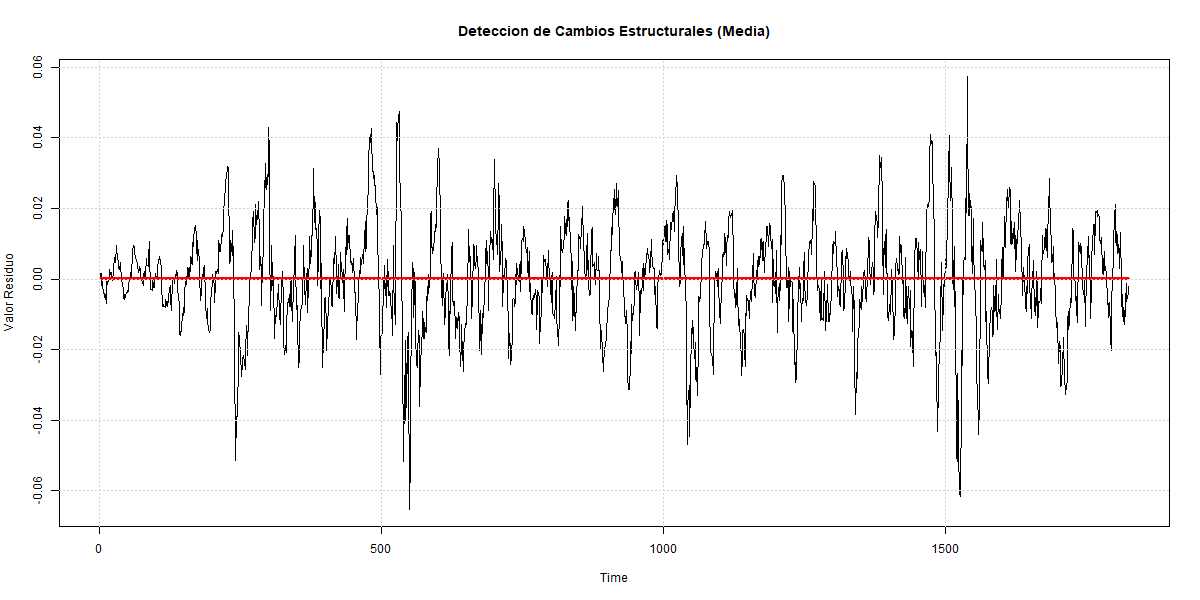

In [21]:
%%R -w 1200 -h 600

# Usamos método PELT (Pruned Exact Linear Time) que es rápido
# penalty="BIC" penaliza encontrar demasiados puntos falsos
cpt_obj <- cpt.mean(df_r$Trend_Removed, method="PELT", penalty="BIC")

# Extraer puntos
cpts_indices <- cpts(cpt_obj)

plot(cpt_obj, type="l", cpt.col="red", cpt.width=3, 
     main="Deteccion de Cambios Estructurales (Media)", 
     ylab="Valor Residuo")
grid()

cat("\n=======================================================\n")
cat(" 4. PUNTOS DE CAMBIO ESTRUCTURAL (Change Points)\n")
cat("=======================================================\n")

if(length(cpts_indices) > 0) {
    cat(paste("Se detectaron", length(cpts_indices), "cambios abruptos en la media.\n"))
    cat("Indices aproximados:", paste(head(cpts_indices, 5), collapse=", "), "...\n")
    cat("Fechas (Primeros 3):", paste(df_r$Date[head(cpts_indices, 3)], collapse=", "), "\n")
} else {
    cat("✅ No se detectaron cambios estructurales significativos en la media.\n")
}


 5. DIAGNOSTICO DE RESIDUOS (Normalidad y Autocorrelacion)

[A] Jarque-Bera Test (Normalidad)
    H0: Los datos se distribuyen normalmente
   -> p-value: 0.00000 (***) 
   -> Conclusion: [!] No Normal (Colas pesadas)

[B] Ljung-Box Test (Ruido Blanco)
    H0: Datos independientes (Sin correlacion serial)
   -> p-value: 0.00000 (***) 
   -> Conclusion: [!] Aun queda autocorrelacion

-------------------------------------------------------
INTERPRETACION FINAL:
1. Si da 'No Normal': Es esperado en electricidad (Kurtosis alta).
   Justifica el uso de evaluacion probabilistica (CRPS) sobre MSE.

2. Si da 'Aun queda autocorrelacion':
   Significa que Lowess no capturo toda la dinamica temporal.
   Los modelos ARMA/LSTM posteriores se encargaran de esto.


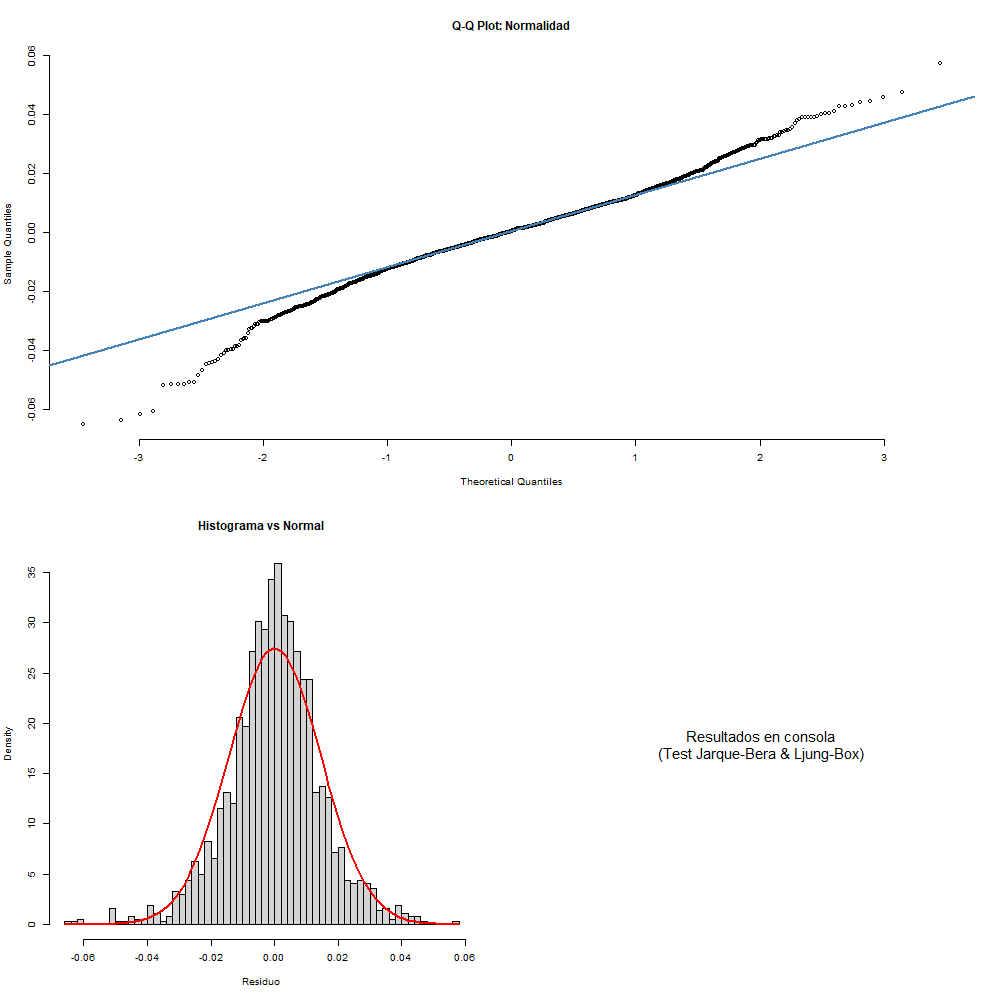

In [22]:
%%R -w 1000 -h 1000

# Datos a analizar
serie_final <- na.omit(df_r$Trend_Removed)

# Configuracion de graficos (2x2)
layout(matrix(c(1,1,2,3), 2, 2, byrow = TRUE))

# 1. QQ-Plot
qqnorm(serie_final, pch = 1, frame = FALSE, main="Q-Q Plot: Normalidad")
qqline(serie_final, col = "steelblue", lwd = 2)

# 2. Histograma
hist(serie_final, breaks=50, probability=TRUE, col="lightgrey", main="Histograma vs Normal", xlab="Residuo")
curve(dnorm(x, mean=mean(serie_final), sd=sd(serie_final)), col="red", lwd=2, add=TRUE)

# 3. Placeholder visual
plot(1, type="n", axes=F, xlab="", ylab="")
text(1, 1, "Resultados en consola\n(Test Jarque-Bera & Ljung-Box)", cex=1.5)

# --- FUNCION LIMPIA (SOLO ASCII) ---
interpret_p <- function(p_val, alpha=0.05, h0_desc, h1_desc) {
    res <- ifelse(p_val < alpha, h1_desc, h0_desc)
    # Marcas de significancia simples
    signif <- ifelse(p_val < 0.001, "***", ifelse(p_val < 0.01, "**", ifelse(p_val < 0.05, "*", "ns")))
    cat(sprintf("   -> p-value: %.5f (%s) \n   -> Conclusion: %s\n", p_val, signif, res))
}

# --- REPORTES DE TEXTO (SIN TILDES NI EMOJIS) ---
cat("\n=======================================================\n")
cat(" 5. DIAGNOSTICO DE RESIDUOS (Normalidad y Autocorrelacion)\n")
cat("=======================================================\n")

# A. Jarque-Bera
cat("\n[A] Jarque-Bera Test (Normalidad)\n")
cat("    H0: Los datos se distribuyen normalmente\n")
jb_test <- jarque.bera.test(serie_final)
interpret_p(jb_test$p.value, h0_desc="[OK] Normal", h1_desc="[!] No Normal (Colas pesadas)")

# B. Ljung-Box
cat("\n[B] Ljung-Box Test (Ruido Blanco)\n")
cat("    H0: Datos independientes (Sin correlacion serial)\n")
# Usamos lag=24 porque tus datos son horarios
lb_test <- Box.test(serie_final, lag=24, type="Ljung-Box") 
interpret_p(lb_test$p.value, h0_desc="[OK] Ruido Blanco", h1_desc="[!] Aun queda autocorrelacion")

cat("\n-------------------------------------------------------\n")
cat("INTERPRETACION FINAL:\n")
cat("1. Si da 'No Normal': Es esperado en electricidad (Kurtosis alta).\n")
cat("   Justifica el uso de evaluacion probabilistica (CRPS) sobre MSE.\n\n")
cat("2. Si da 'Aun queda autocorrelacion':\n")
cat("   Significa que Lowess no capturo toda la dinamica temporal.\n")
cat("   Los modelos ARMA/LSTM posteriores se encargaran de esto.\n")

In [23]:
# Enriquecer dataset para boxplots

df['Dia_Semana'] = df.index.day_name()
df['Mes'] = df.index.month_name()


# 2. Por Día de la Semana
dias_orden = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
fig = px.box(df, x='Dia_Semana', y='Trend_Removed', category_orders={"Dia_Semana": dias_orden},
             title='Box Plot: Estacionalidad Semanal', color_discrete_sequence=['orange'])
fig.update_layout(title_x=0.5)
fig.show()

# 1. Por Mes (Ciclo Diario - Fundamental en electricidad)
fig = px.box(df, x='Mes', y='Trend_Removed', 
             title='Box Plot: Estacionalidad Diaria (Por Mes)', color_discrete_sequence=['blue'])
fig.update_layout(title_x=0.5)
fig.show()

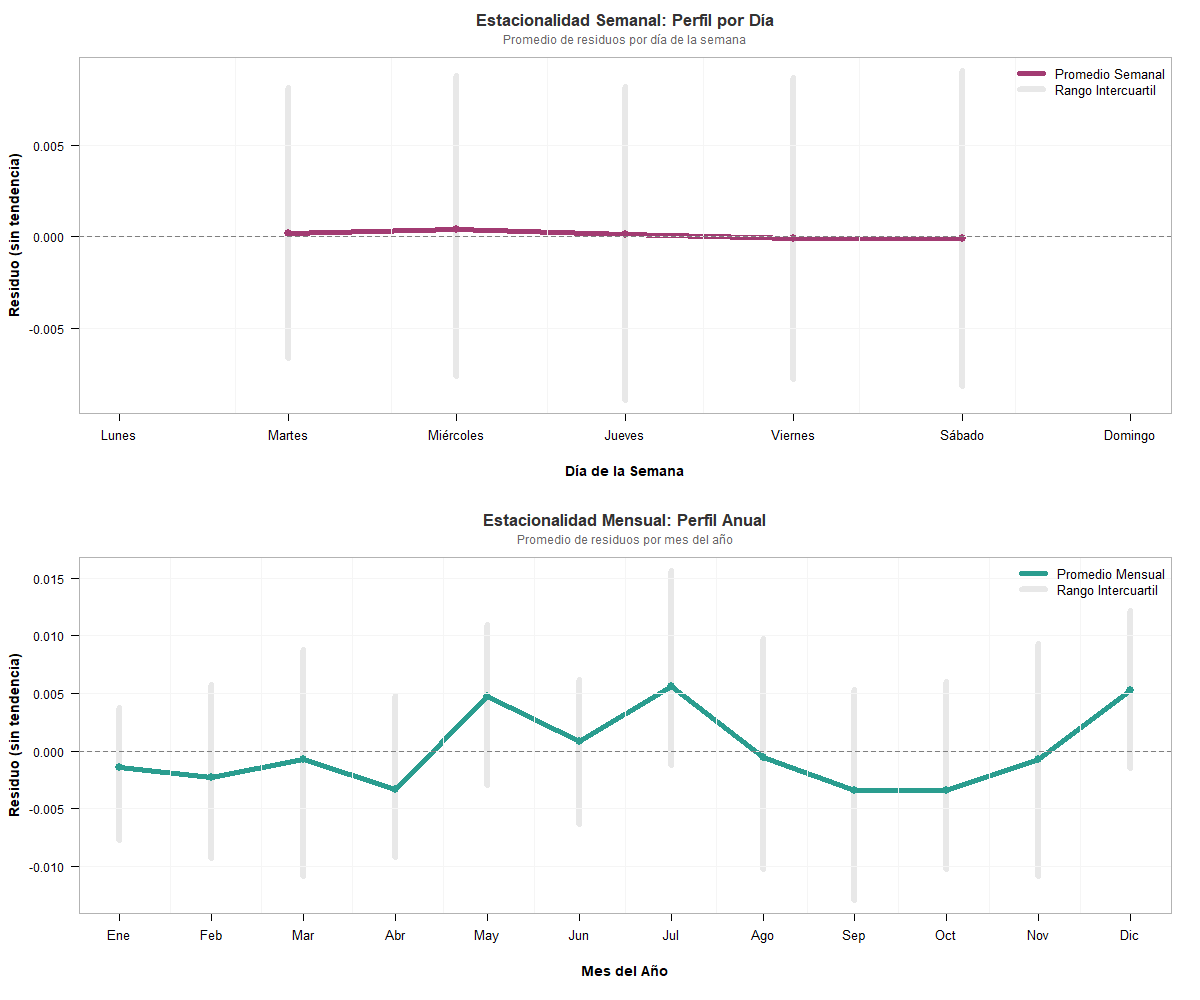

In [24]:
%%R -w 1200 -h 1000

library(dplyr)
library(lubridate)

# Paleta de colores moderna
col_weekly <- "#A23B72"      # Magenta oscuro
col_monthly <- "#2A9D8F"     # Verde azulado (nuevo para mensual)
col_base <- "#E8E8E8"        # Gris claro para variación
col_grid <- "#F5F5F5"        # Grid muy suave

# Configuración del panel mejorada
layout(matrix(c(1, 2), nrow = 2, ncol = 1))
par(mar = c(6, 5.5, 4, 2), 
    bg = "white",
    family = "sans")

# ==============================================================================
# 1. ESTACIONALIDAD SEMANAL (Ciclo de 7 Días)
# ==============================================================================

# Calcular promedios por día de la semana
daily_agg <- df_r %>%
  mutate(Date_Day = as.Date(Date),
         Weekday = wday(Date_Day, week_start = 1)) %>%  # 1=Lunes, 7=Domingo
  group_by(Date_Day, Weekday) %>%
  summarise(Value = mean(Trend_Removed, na.rm = TRUE), .groups = "drop")

weekly_stats <- daily_agg %>%
  group_by(Weekday) %>%
  summarise(
    Mean = mean(Value, na.rm = TRUE),
    Q25 = quantile(Value, 0.25, na.rm = TRUE),
    Q75 = quantile(Value, 0.75, na.rm = TRUE)
  )

dias_semana <- c("Lunes", "Martes", "Miércoles", "Jueves", 
                 "Viernes", "Sábado", "Domingo")

plot(weekly_stats$Weekday, weekly_stats$Mean,
     type = "n",
     xlim = c(1, 7),
     ylim = range(c(weekly_stats$Q25, weekly_stats$Q75)),
     xlab = "", ylab = "", main = "", xaxt = "n", las = 1)

# Bandas de variación
for(i in 1:nrow(weekly_stats)) {
  segments(weekly_stats$Weekday[i], weekly_stats$Q25[i],
           weekly_stats$Weekday[i], weekly_stats$Q75[i],
           col = col_base, lwd = 6)
}

lines(weekly_stats$Weekday, weekly_stats$Mean, col = col_weekly, lwd = 5)
points(weekly_stats$Weekday, weekly_stats$Mean, col = col_weekly, pch = 19, cex = 1.5)

axis(1, at = 1:7, labels = dias_semana, cex.axis = 1.1)
mtext("Estacionalidad Semanal: Perfil por Día", side = 3, line = 2, cex = 1.4, font = 2, col = "gray20")
mtext("Promedio de residuos por día de la semana", side = 3, line = 0.8, cex = 1, col = "gray40")
mtext("Día de la Semana", side = 1, line = 3.5, cex = 1.2, font = 2)
mtext("Residuo (sin tendencia)", side = 2, line = 4, cex = 1.2, font = 2)

grid(nx = 7, ny = NULL, col = col_grid, lty = 1, lwd = 1.5)
abline(h = 0, col = "gray50", lty = 2, lwd = 1.5)
legend("topright", legend = c("Promedio Semanal", "Rango Intercuartil"), 
       col = c(col_weekly, col_base), lty = 1, lwd = c(5, 6), bty = "n", cex = 1.1)
box(col = "gray70", lwd = 1.5)


# ==============================================================================
# 2. ESTACIONALIDAD MENSUAL (Ciclo de 12 Meses)
# ==============================================================================

# Calcular promedios por mes
monthly_stats <- df_r %>%
  mutate(Month = month(Date)) %>%
  group_by(Month) %>%
  summarise(
    Mean = mean(Trend_Removed, na.rm = TRUE),
    Q25 = quantile(Trend_Removed, 0.25, na.rm = TRUE),
    Q75 = quantile(Trend_Removed, 0.75, na.rm = TRUE)
  )

meses_anio <- c("Ene", "Feb", "Mar", "Abr", "May", "Jun", 
                "Jul", "Ago", "Sep", "Oct", "Nov", "Dic")

plot(monthly_stats$Month, monthly_stats$Mean,
     type = "n",
     xlim = c(1, 12),
     ylim = range(c(monthly_stats$Q25, monthly_stats$Q75)),
     xlab = "", ylab = "", main = "", xaxt = "n", las = 1)

# Bandas de variación
for(i in 1:nrow(monthly_stats)) {
  segments(monthly_stats$Month[i], monthly_stats$Q25[i],
           monthly_stats$Month[i], monthly_stats$Q75[i],
           col = col_base, lwd = 6)
}

lines(monthly_stats$Month, monthly_stats$Mean, col = col_monthly, lwd = 5)
points(monthly_stats$Month, monthly_stats$Mean, col = col_monthly, pch = 19, cex = 1.5)

axis(1, at = 1:12, labels = meses_anio, cex.axis = 1.1)
mtext("Estacionalidad Mensual: Perfil Anual", side = 3, line = 2, cex = 1.4, font = 2, col = "gray20")
mtext("Promedio de residuos por mes del año", side = 3, line = 0.8, cex = 1, col = "gray40")
mtext("Mes del Año", side = 1, line = 3.5, cex = 1.2, font = 2)
mtext("Residuo (sin tendencia)", side = 2, line = 4, cex = 1.2, font = 2)

grid(nx = 12, ny = NULL, col = col_grid, lty = 1, lwd = 1.5)
abline(h = 0, col = "gray50", lty = 2, lwd = 1.5)
legend("topright", legend = c("Promedio Mensual", "Rango Intercuartil"), 
       col = c(col_monthly, col_base), lty = 1, lwd = c(5, 6), bty = "n", cex = 1.1)
box(col = "gray70", lwd = 1.5)

[1] "Periodo Dominante en R: 49.3421 horas"


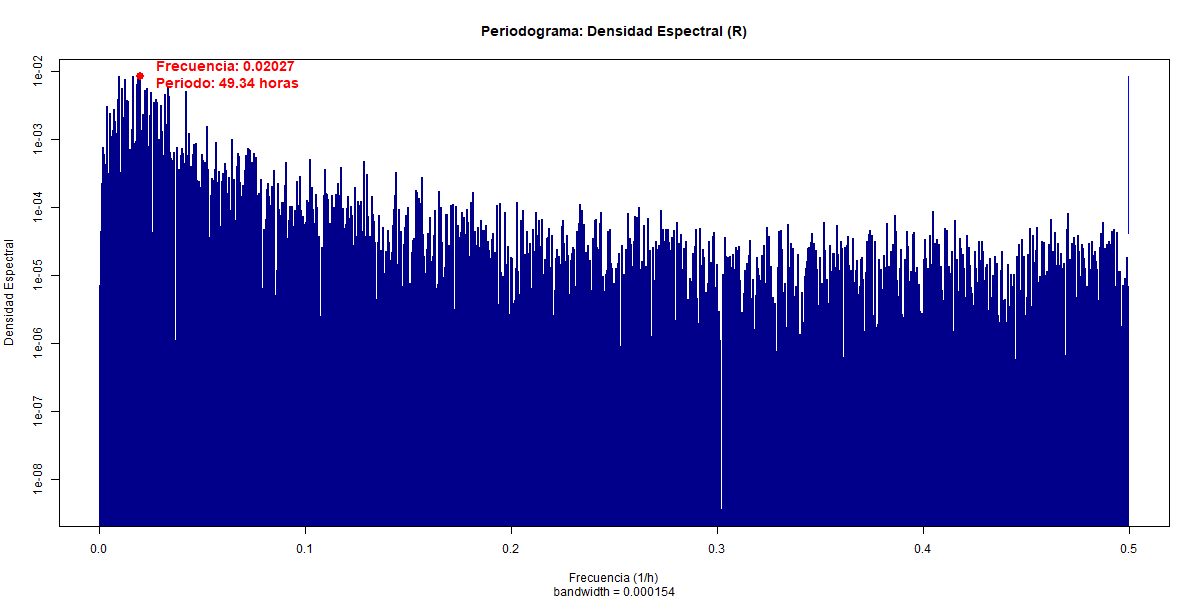

In [25]:
%%R -w 1200 -h 600

# 1. Preparar datos (quitamos NAs generados por el filtro de tendencia)
clean_data <- na.omit(df_r$Trend_Removed)

# 2. Calcular el periodograma
# log='no' para ver la densidad espectral cruda
Periogram <- spectrum(as.numeric(clean_data), log = 'no', plot = FALSE)

# 3. Encontrar el pico máximo
ubicacion <- which.max(Periogram$spec)
max_freq <- Periogram$freq[ubicacion]
max_spec <- Periogram$spec[ubicacion]

# 4. Calcular el periodo correspondiente (1 / frecuencia)
max_period <- 1 / max_freq

# 5. Graficar
plot(Periogram, 
     main = "Periodograma: Densidad Espectral (R)",
     xlab = "Frecuencia (1/h)",
     ylab = "Densidad Espectral",
     col = "darkblue", lwd = 2, type="h")

# Marcamos el punto máximo
points(max_freq, max_spec, col = "red", pch = 19, cex = 1.5)

# 6. Texto dinámico (ajustado para que no quede fuera del gráfico)
# Usamos max_spec para la altura y max_freq para la posición X
text_x <- max_freq
text_y <- max_spec

text(text_x, text_y, 
     sprintf("  Frecuencia: %.5f\n  Periodo: %.2f horas", max_freq, max_period), 
     pos = 4,      # Texto a la derecha del punto
     col = "red", 
     cex = 1.2, 
     font = 2)

print(paste("Periodo Dominante en R:", round(max_period, 4), "horas"))

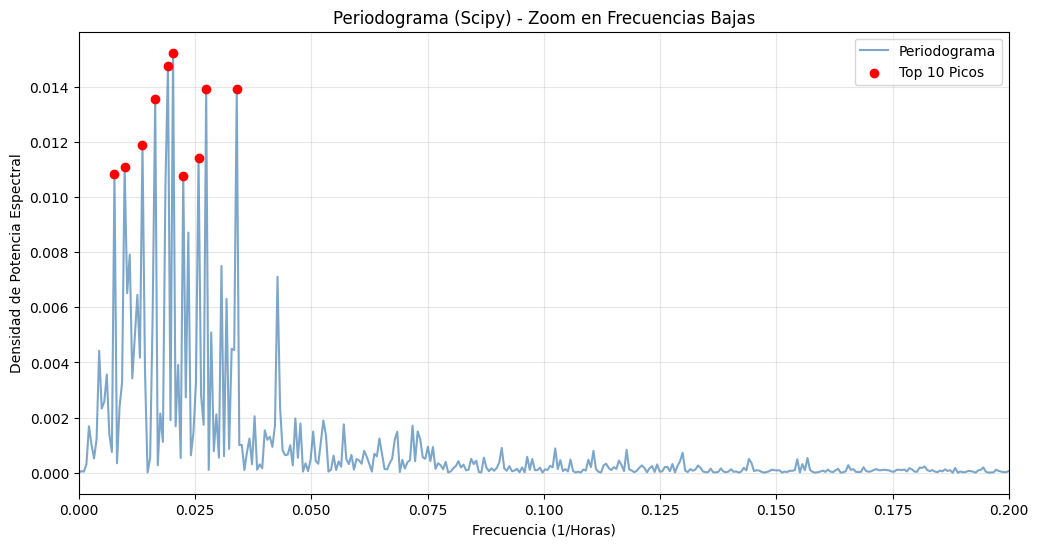

--- Los 10 Picos más grandes (Periodograma) ---


,0,1,2,3,4,5,6,7,8,9
Frecuencia,0.020274,0.019178,0.027397,0.033973,0.016438,0.013699,0.025753,0.009863,0.007671,0.022466
Periodo (Horas),49.324324,52.142857,36.500000,29.435484,60.833333,73.000000,38.829787,101.388889,130.357143,44.512195
Densidad Potencia,0.015230,0.014748,0.013910,0.013907,0.013564,0.011898,0.011409,0.011102,0.010843,0.010772


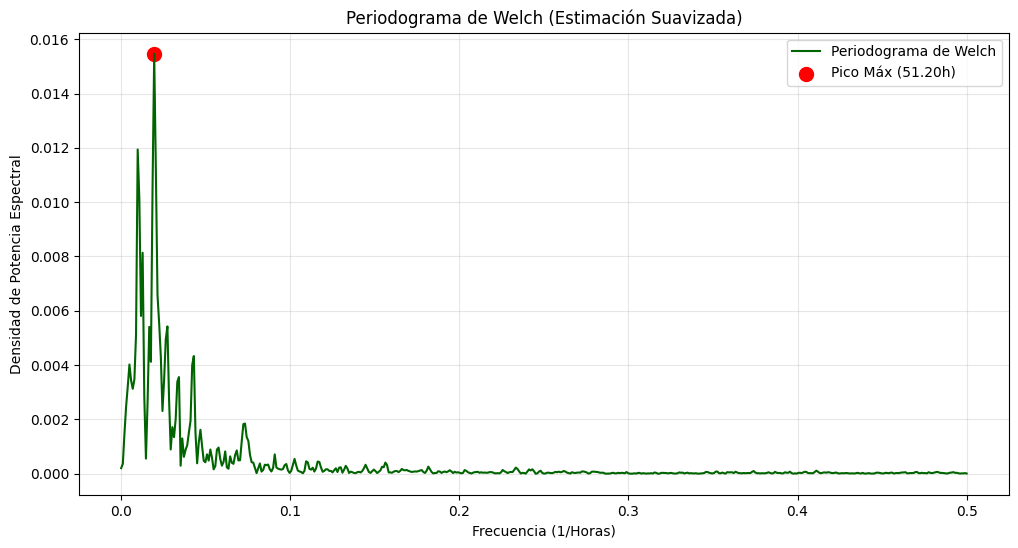


RESULTADO WELCH:
--------------------------------------------
El pico más notorio se da: 
 - Frecuencia: 0.01953 Hz (ciclos/hora)
 - Periodo:    51.20 Horas
 - Densidad:   0.02
--------------------------------------------



In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.signal as signal
import heapq

# 1. Preparar datos (Eliminar NAs es crucial para FFT)
trend_removed = df['Trend_Removed'].dropna()

# ==========================================
# A. PERIODOGRAMA ESTÁNDAR
# ==========================================

# Calcular el periodograma
f, Pxx_den = signal.periodogram(trend_removed)

# Encontrar los 10 picos más importantes
# Usamos heapq para buscar los índices de los valores más altos
peaks_indices = heapq.nlargest(10, range(len(Pxx_den)), key=Pxx_den.__getitem__)

f_freq = f[peaks_indices]
densidad = Pxx_den[peaks_indices]

# Evitar división por cero si la frecuencia 0 (DC) es seleccionada
with np.errstate(divide='ignore'):
    f_period = 1 / f_freq

# Graficar el periodograma estándar
plt.figure(figsize=(12, 6))
plt.plot(f, Pxx_den, label='Periodograma', color='steelblue', alpha=0.7)
plt.scatter(f[peaks_indices], Pxx_den[peaks_indices], color='red', zorder=5, label='Top 10 Picos')

# Zoom opcional: limitamos X para ver mejor las frecuencias bajas (donde están los ciclos de 24h y 168h)
plt.xlim(0, 0.2) 

plt.xlabel('Frecuencia (1/Horas)')
plt.ylabel('Densidad de Potencia Espectral')
plt.title('Periodograma (Scipy) - Zoom en Frecuencias Bajas')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print('--- Los 10 Picos más grandes (Periodograma) ---')

# Crear DataFrame con resultados
data = {
    'Frecuencia': f_freq, 
    'Periodo (Horas)': f_period, 
    'Densidad Potencia': densidad
}
df_frecuencias_periodos = pd.DataFrame(data).sort_values(by='Densidad Potencia', ascending=False)

# Mostrar tabla traspuesta para fácil lectura
display(df_frecuencias_periodos.T)


# ==========================================
# B. PERIODOGRAMA DE WELCH (Más suave)
# ==========================================

# Calcular Welch (nperseg define la resolución, 1024 es bueno para hourly)
f_welch, Pxx_den_welch = signal.welch(trend_removed, nperseg=1024)

# Encontrar el pico más alto
max_index_value_welch = np.argmax(Pxx_den_welch)
frecuencia_max_welch = f_welch[max_index_value_welch]
frecuencia_pico_welch = 1 / frecuencia_max_welch
max_densidad_welch = Pxx_den_welch[max_index_value_welch]

# Graficar Welch
plt.figure(figsize=(12, 6))
plt.plot(f_welch, Pxx_den_welch, label='Periodograma de Welch', color='darkgreen')
plt.scatter(frecuencia_max_welch, max_densidad_welch, color='red', s=100, label=f'Pico Máx ({frecuencia_pico_welch:.2f}h)')

plt.xlabel('Frecuencia (1/Horas)')
plt.ylabel('Densidad de Potencia Espectral')
plt.title('Periodograma de Welch (Estimación Suavizada)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"""
RESULTADO WELCH:
--------------------------------------------
El pico más notorio se da: 
 - Frecuencia: {frecuencia_max_welch:.5f} Hz (ciclos/hora)
 - Periodo:    {frecuencia_pico_welch:.2f} Horas
 - Densidad:   {max_densidad_welch:.2f}
--------------------------------------------
""")

# 📊 Análisis Completo de Series de Tiempo
## Dataset: Consumo Eléctrico (Electricity)

**Autor:** [Tu Nombre]  
**Fecha:** Diciembre 2025  
**Objetivo:** Análisis exploratorio completo de series de tiempo con enfoque en detección de no linealidad y estacionalidad

---

## 📑 Tabla de Contenidos

1. [Configuración Inicial](#1-configuracion)
2. [Importación y Preparación de Datos](#2-datos)
3. [Transformación Box-Cox (Estabilización de Varianza)](#3-boxcox)
4. [Descomposición de Series](#4-descomposicion)
5. [Eliminación de Tendencia](#5-tendencia)
6. [Análisis de Autocorrelación](#6-autocorrelacion)
7. [Tests de Estacionariedad](#7-estacionariedad)
8. [Tests de No Linealidad](#8-nolinealidad)
9. [Análisis de Heterocedasticidad](#9-heterocedasticidad)
10. [Detección de Cambios Estructurales](#10-cambios)
11. [Diagnóstico de Residuos](#11-diagnostico)
12. [Análisis de Estacionalidad](#12-estacionalidad)
13. [Análisis Espectral](#13-espectral)
14. [Preparación para Modelado](#14-modelado)

---

## 1. Configuración Inicial {#1-configuracion}



### 1.1 Instalación de Dependencias

**Instrucciones:**
- Asegúrate de tener R instalado (v4.0+)
- Instala `rpy2` en Python: `pip install rpy2`
- En Windows, puede ser necesario configurar `R_HOME`

In [27]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.graph_objects as go
import plotly.express as px
from gluonts.dataset.repository import get_dataset
import os

# Configuración de rpy2
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter

# Cargar extensión mágica para usar %%R
%load_ext rpy2.ipython

warnings.filterwarnings('ignore')

print("✅ Librerías Python cargadas correctamente")


The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython
✅ Librerías Python cargadas correctamente


In [28]:
def plot_(title, *series):
    """
    Función para crear gráficos interactivos estilo Bancolombia
    
    Args:
        title (str): Título del gráfico
        *series: Tuplas (x, y, label) para cada serie
    """
    fig = go.Figure()
    
    for x_variable, y_variable, label in series:
        fig.add_trace(go.Scatter(
            x=x_variable, y=y_variable, mode='lines', 
            name=label, line=dict(width=1.5)
        ))
    
    fig.update_layout(
        title=dict(text=title, x=0.5, xanchor='center'),
        template='plotly_white',
        margin=dict(t=120, b=100),
        legend=dict(
            orientation="h",
            yanchor="top",
            y=-0.3,
            xanchor="center",
            x=0.5
        )
    )

    fig.update_xaxes(
        type='date',
        rangeselector=dict(
            x=0,
            y=1.05,
            buttons=list([
                dict(count=24, label="24h", step="hour", stepmode="backward"),
                dict(count=7, label="1w", step="day", stepmode="backward"),
                dict(step="all")
            ])
        ),
        rangeslider=dict(visible=True)
    )

    fig.update_yaxes(autorange=True, title="Valor")
    fig.show()


def plot_matplotlib(title, *series):
    """
    Función para crear gráficos estilo financiero usando Matplotlib
    
    Args:
        title (str): Título del gráfico
        *series: Tuplas (x, y, label) para cada serie
    """
    # Configurar el estilo de fondo blanco y cuadrícula suave
    plt.style.use('seaborn-v0_8-whitegrid')
    
    # Crear la figura
    fig, ax = plt.subplots(figsize=(12, 7))
    
    # Graficar cada serie
    for x_variable, y_variable, label in series:
        ax.plot(x_variable, y_variable, label=label, linewidth=1.5)
    
    # Título (centrado y con espacio superior)
    ax.set_title(title, fontsize=16, fontweight='bold', pad=30, loc='center')
    
    # Configurar el eje X como fecha
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    
    # Rotar fechas para mejor lectura
    plt.xticks(rotation=0)
    
    # Etiqueta del eje Y
    ax.set_ylabel("Valor", fontsize=12)
    
    # Estilo de los bordes (Spines)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # --- LEYENDA ESTILO BANCOLOMBIA (Horizontal abajo) ---
    # bbox_to_anchor mueve la leyenda fuera del eje. 
    # (0.5, -0.2) significa: centro horizontal, 20% abajo del gráfico.
    ax.legend(
        loc='upper center', 
        bbox_to_anchor=(0.5, -0.15),
        ncol=len(series) if len(series) > 0 else 1,
        frameon=False,
        fontsize=11
    )
    
    # Ajustar márgenes para que la leyenda no se corte
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.2) # Espacio extra abajo para la leyenda
    
    plt.show()
    
print("✅ Función de graficado definida")

✅ Función de graficado definida


### 1.2 Instalación de Paquetes R

In [29]:
%%R

paquetes_necesarios <- c(
    "forecast",      # ARIMA, MSTL, Box-Cox
    "astsa",         # Análisis de series temporales avanzado
    "nonlinearTseries", # Tests de no linealidad
    "tidyverse",     # Manipulación de datos
    "lubridate",     # Manejo de fechas
    "tseries",       # ADF, KPSS
    "FinTS",         # Test ARCH
    "changepoint",   # Detección de cambios estructurales
    "nortest",       # Tests de normalidad
    "strucchange",   # Cambios estructurales
    "tsDyn"          # Modelos no lineales
)

for (pkg in paquetes_necesarios) {
    if (!require(pkg, character.only = TRUE)) {
        install.packages(pkg, dependencies = TRUE)
        library(pkg, character.only = TRUE)
    }
}

cat("✅ Todos los paquetes de R instalados correctamente\n")

<U+2705> Todos los paquetes de R instalados correctamente


---

## 2. Importación y Preparación de Datos {#2-datos}

**Descripción del Dataset:**
- **Fuente:** GluonTS - Dataset "Electricity"
- **Frecuencia:** Horaria
- **Variable:** Consumo eléctrico (kWh)
- **Ventana de análisis:** Últimas 2160 observaciones (~90 días)

In [30]:
# Cargar Dataset Exchange Rate
dataset = get_dataset("exchange_rate")
series_entry = next(iter(dataset.train)) # Tomamos la primera serie (índice 0)

# Recortamos a los últimos 4000 datos para agilizar el análisis visual
# y evitar saturar R
LIMIT = 1825
values = series_entry['target'][-LIMIT:]
start_date = pd.Timestamp(series_entry['start'].to_timestamp())
freq = series_entry['start'].freq

# Crear índice de fechas
timestamps = pd.date_range(
    end=start_date + pd.Timedelta(hours=len(series_entry['target'])), 
    periods=len(series_entry['target']), 
    freq=freq
)[-LIMIT:]

df = pd.DataFrame({'Date': timestamps, 'Tasa': values}) # Usamos 'Tasa' para mantener consistencia con el dataset
df.set_index('Date', inplace=True)

print(f"Dimensiones: {df.shape}")
display(df.head())

plot_('Exchange Rate', (df.index, df["Tasa"], "Tasa"))

Dimensiones: (1825, 1)


,Tasa
Date,
1983-09-13 23:00:00,0.74600
1983-09-14 23:00:00,0.74525
1983-09-15 23:00:00,0.74755
1983-09-16 23:00:00,0.74375
1983-09-19 23:00:00,0.74585


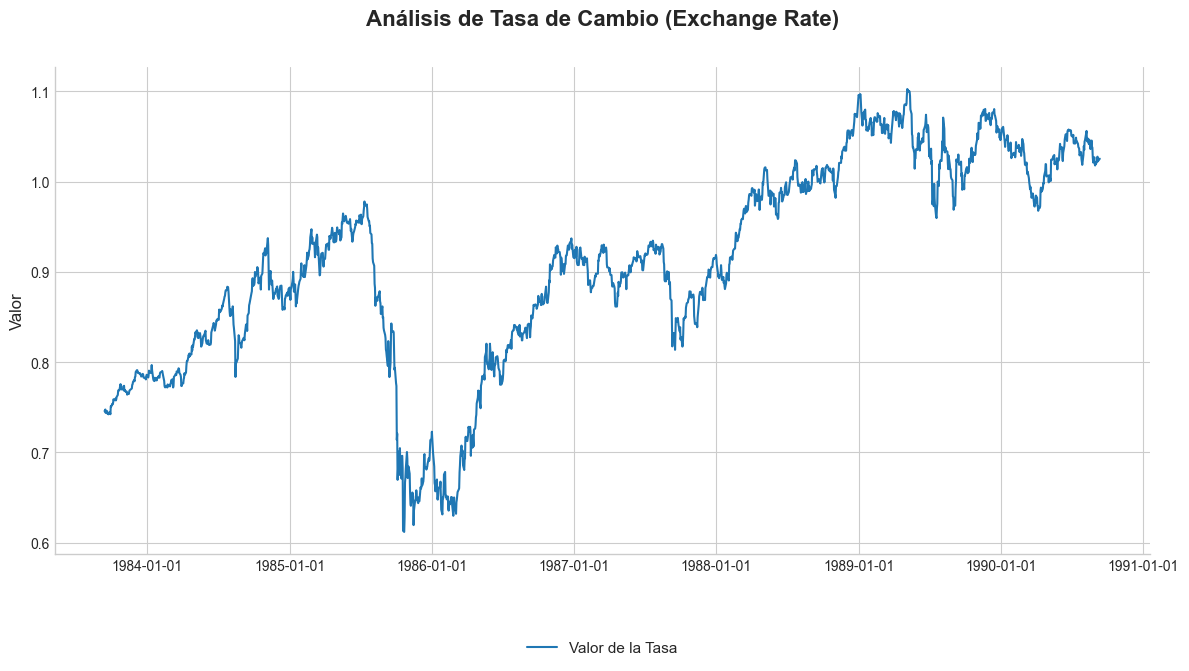

In [31]:

# Nota: Estas funciones suelen esperar una tupla (índice, valores, etiqueta)
plot_('Análisis de Tasa de Cambio (Exchange Rate)', 
      (df.index, df["Tasa"], "Valor de la Tasa"))

plot_matplotlib('Análisis de Tasa de Cambio (Exchange Rate)',
                (df.index, df["Tasa"], "Valor de la Tasa"))

### 2.1 Preparación para Análisis en R

⚠️ **Nota importante:** Detectamos si hay valores ≤ 0 para aplicar offset (Box-Cox requiere valores positivos)

In [32]:
df_r = df.reset_index()
df_r['Date'] = df_r['Date'].dt.strftime('%Y-%m-%d %H:%M:%S')

# Detección y corrección de valores no positivos
min_val = df_r['Tasa'].min()
offset = 0

if min_val <= 0:
    offset = abs(min_val) + 1.0
    print(f"⚠️ Valores ≤ 0 detectados. Aplicando offset de {offset}")
else:
    print("✅ Todos los valores son positivos")

df_r['Consumo_Offset'] = df_r['Tasa'] + offset
print(f"📊 Rango de valores: [{df_r['Consumo_Offset'].min():.2f}, {df_r['Consumo_Offset'].max():.2f}]")

✅ Todos los valores son positivos
📊 Rango de valores: [0.61, 1.10]


In [33]:
%%R -i df_r
# Celda 7: Convertir fechas en R
df_r$Date <- as.POSIXct(df_r$Date, format="%Y-%m-%d %H:%M:%S")
cat("✅ Datos cargados en R\n")
cat("Dimensiones:", nrow(df_r), "x", ncol(df_r), "\n")
head(df_r, 3)

<U+2705> Datos cargados en R
Dimensiones: 1825

 x 3 
                 Date    Tasa Consumo_Offset
0 1983-09-13 23:00:00 0.74600        0.74600
1 1983-09-14 23:00:00 0.74525        0.74525
2 1983-09-15 23:00:00 0.74755        0.74755


---

## 3. Transformación Box-Cox (Estabilización de Varianza) {#3-boxcox}

**Objetivo:** Estabilizar la varianza heterocedástica mediante transformación Box-Cox

**Teoría:**
- λ = 1 → Sin transformación
- λ = 0.5 → Raíz cuadrada
- λ = 0 → Logaritmo
- λ = -1 → Inverso


RESULTADOS:
Lambda estimado: 1.9999 
Interpretacion:
  -> Casi sin transformacion necesaria


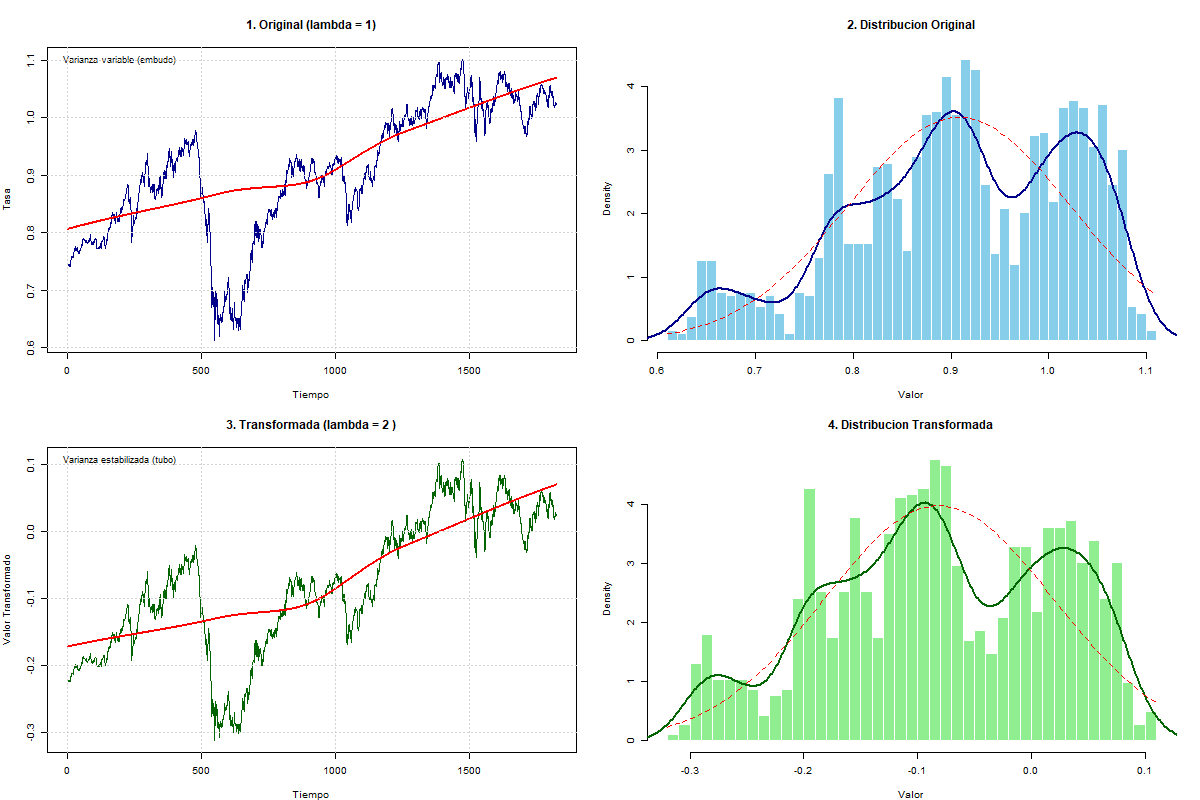

In [34]:
%%R -w 1200 -h 800
# Celda 8: Análisis Visual Box-Cox (4 paneles)

library(forecast)

# Calcular lambda optimo (método Guerrero para series temporales)
lambda_opt <- BoxCox.lambda(df_r$Consumo_Offset, method = "guerrero")

data_orig <- df_r$Consumo_Offset
data_trans <- BoxCox(df_r$Consumo_Offset, lambda_opt)

# Panel de 4 gráficos
par(mfrow=c(2,2), mar=c(4,4,4,2))

# 1. Serie Original
plot(data_orig, type="l", col="darkblue", 
     main="1. Original (lambda = 1)", ylab="Tasa", xlab="Tiempo")
lines(lowess(data_orig), col="red", lwd=2)
legend("topleft", legend="Varianza variable (embudo)", bty="n", cex=0.9)
grid()

# 2. Histograma Original
hist(data_orig, breaks=50, col="skyblue", border="white", probability=TRUE,
     main="2. Distribucion Original", xlab="Valor")
lines(density(data_orig), col="darkblue", lwd=2)
curve(dnorm(x, mean=mean(data_orig), sd=sd(data_orig)), 
      add=TRUE, col="red", lty=2)

# 3. Serie Transformada
plot(data_trans, type="l", col="darkgreen", 
     main=paste("3. Transformada (lambda =", round(lambda_opt, 3), ")"),
     ylab="Valor Transformado", xlab="Tiempo")
lines(lowess(data_trans), col="red", lwd=2)
legend("topleft", legend="Varianza estabilizada (tubo)", bty="n", cex=0.9)
grid()

# 4. Histograma Transformado
hist(data_trans, breaks=50, col="lightgreen", border="white", probability=TRUE,
     main="4. Distribucion Transformada", xlab="Valor")
lines(density(data_trans), col="darkgreen", lwd=2)
curve(dnorm(x, mean=mean(data_trans), sd=sd(data_trans)), 
      add=TRUE, col="red", lty=2)

par(mfrow=c(1,1))

cat("\nRESULTADOS:\n")
# Usamos 'lambda' en vez del símbolo griego para evitar problemas de encoding
cat("Lambda estimado:", round(lambda_opt, 4), "\n")
cat("Interpretacion:\n")
if (lambda_opt > 0.9) {
    cat("  -> Casi sin transformacion necesaria\n")
} else if (lambda_opt > 0.4) {
    cat("  Transformacion moderada (similar a raiz cuadrada)\n")
} else {
    cat("  Transformacion fuerte (similar a logaritmo)\n")
}

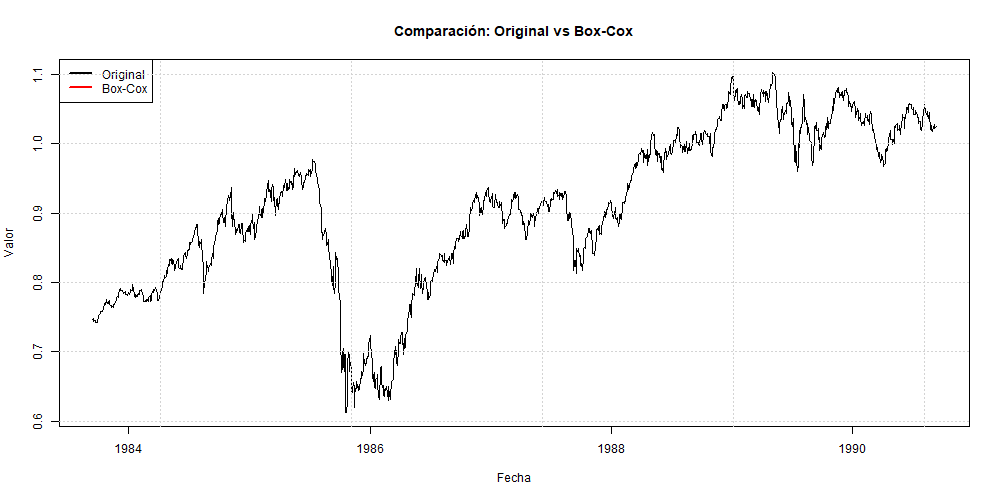

In [35]:
%%R -w 1000 -h 500
# Celda 9: Comparación Directa Original vs Box-Cox

Lambda_est <- BoxCox.lambda(df_r$Consumo_Offset, method = "guerrero")

plot(df_r$Date, df_r$Consumo_Offset, type="l", col="black", 
     main="Comparación: Original vs Box-Cox", ylab="Valor", xlab="Fecha")
lines(df_r$Date, BoxCox(df_r$Consumo_Offset, Lambda_est), col="red")
legend("topleft", legend=c("Original", "Box-Cox"), 
       col=c("black", "red"), lty=1, lwd=2)
grid()

# Guardar transformación
df_r$BoxCox_Consumo <- BoxCox(df_r$Consumo_Offset, Lambda_est)

In [36]:
# Celda 10: Traer resultados a Python
df['BoxCox_Consumo'] = %R df_r$BoxCox_Consumo
lambda_r = %R Lambda_est

plot_(f'🔄 Estabilización de Varianza (Box-Cox λ={lambda_r[0]:.3f})', 
      (df.index, df["Tasa"], "Datos Originales"),
      (df.index, df["BoxCox_Consumo"], "Box-Cox Transformado"))

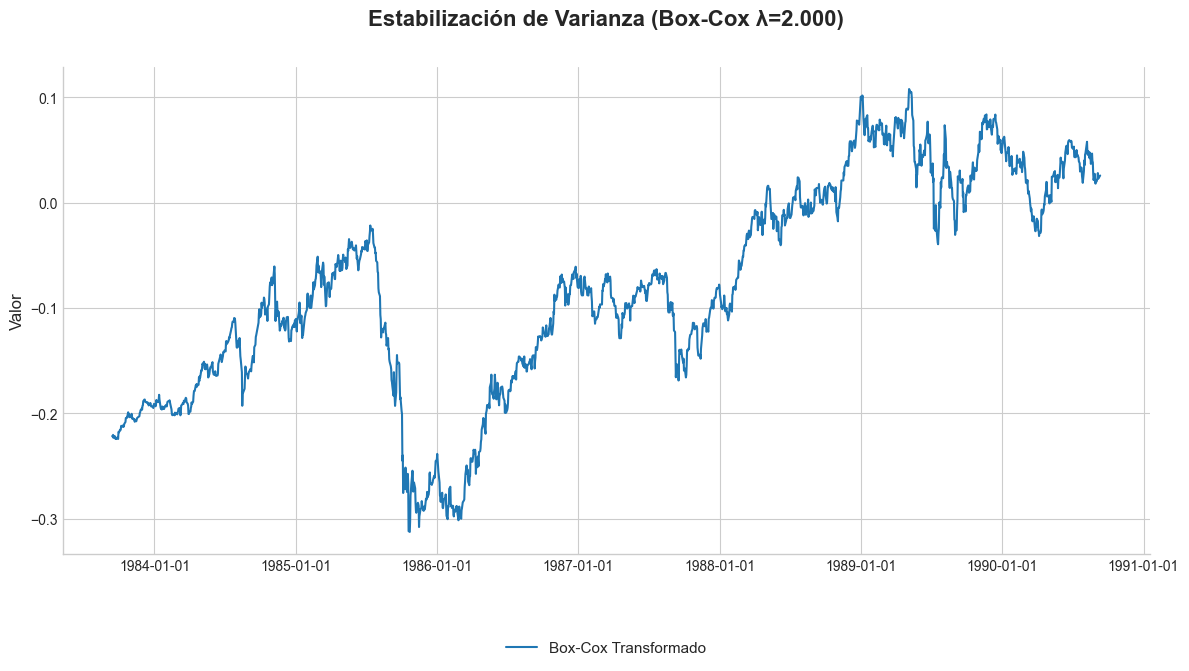

In [37]:
plot_matplotlib(f'Estabilización de Varianza (Box-Cox λ={lambda_r[0]:.3f})',
                (df.index, df["BoxCox_Consumo"], "Box-Cox Transformado"))


---

## 4. Descomposición de Series {#4-descomposicion}

**Método:** MSTL (Multiple Seasonal-Trend decomposition using Loess)

**Componentes:**
- **Tendencia:** Movimiento de largo plazo
- **Estacionalidad Diaria:** Ciclo de 24 horas
- **Estacionalidad Semanal:** Ciclo de 168 horas (7 días)
- **Residuo:** Componente aleatorio


--- COMPONENTES IDENTIFICADOS ---
1. Tendencia global
2. Estacionalidad diaria (24h)
3. Estacionalidad semanal (168h)
4. Componente residual


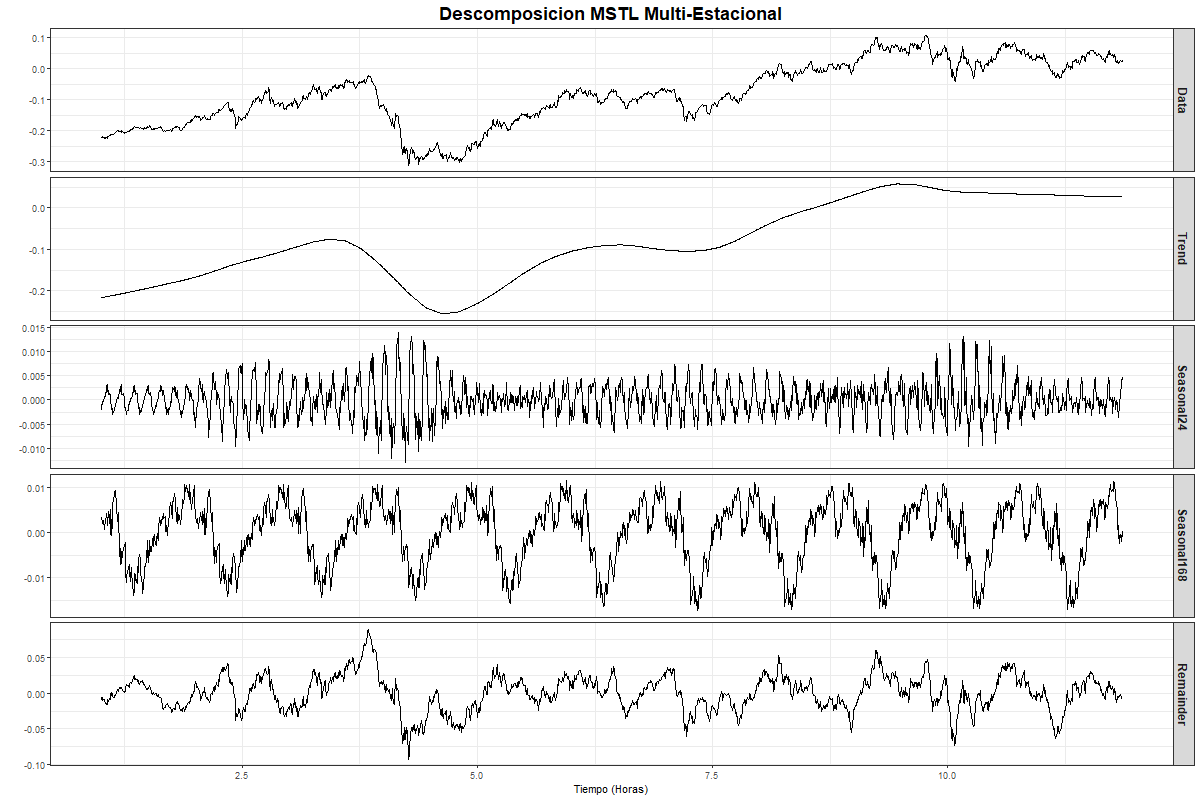

In [38]:
%%R -w 1200 -h 800
# Celda 11: Descomposicion MSTL

library(forecast)
library(ggplot2)

# Crear objeto multi-estacional
# Asegúrate de que df_r$BoxCox_Consumo existe de celdas anteriores
y_msts <- msts(df_r$BoxCox_Consumo, seasonal.periods=c(24, 168))

# Ajustar MSTL
fit_mstl <- mstl(y_msts)

# Visualizacion (Guardamos en variable p y usamos print)
p <- autoplot(fit_mstl) + 
  ggtitle("Descomposicion MSTL Multi-Estacional") +
  xlab("Tiempo (Horas)") +
  theme_bw() +
  theme(
    plot.title = element_text(size=18, face="bold", hjust=0.5),
    strip.text = element_text(size=12, face="bold")
  )

print(p)

cat("\n--- COMPONENTES IDENTIFICADOS ---\n")
cat("1. Tendencia global\n")
cat("2. Estacionalidad diaria (24h)\n")
cat("3. Estacionalidad semanal (168h)\n")
cat("4. Componente residual\n")

---

## 5. Eliminación de Tendencia {#5-tendencia}

**Método:** LOWESS (Locally Weighted Scatterplot Smoothing)

**Parámetros:**
- `f = 0.05`: Ventana de suavizado (5% de los datos)
- Menor f → Sigue más los datos locales
- Mayor f → Suavizado más pronunciado



 Tendencia extraida exitosamente
 Varianza antes: 0.0101 
 Varianza despues: 2e-04 


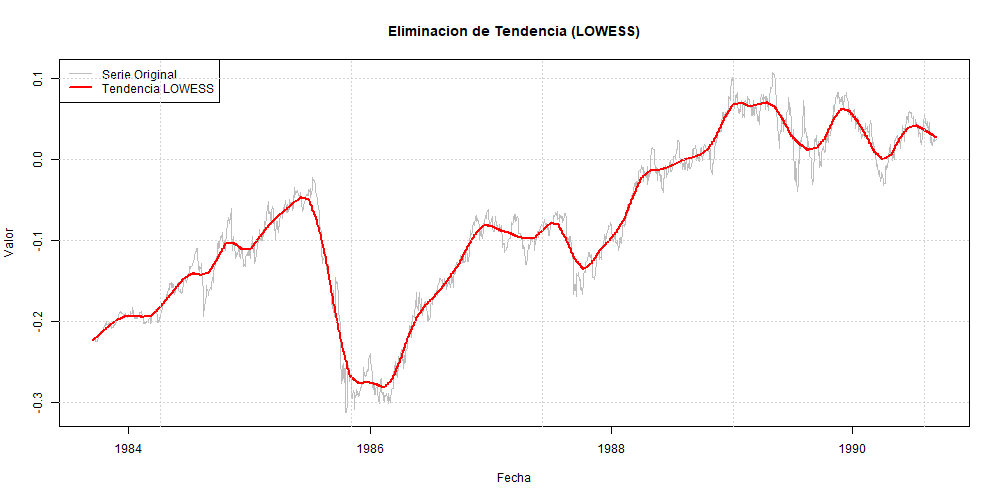

In [39]:
%%R -w 1000 -h 500
# Celda 12: Eliminación de Tendencia con LOWESS

trend_lowess_R <- lowess(df_r$BoxCox_Consumo, f = 0.05, iter = 0)

df_r$Trend <- trend_lowess_R$y
df_r$Trend_Removed <- df_r$BoxCox_Consumo - df_r$Trend

# Visualización
plot(df_r$Date, df_r$BoxCox_Consumo, type='l', col='gray', 
     main='Eliminacion de Tendencia (LOWESS)', 
     ylab='Valor', xlab='Fecha')
lines(df_r$Date, df_r$Trend, col='red', lwd=2)
legend("topleft", legend=c("Serie Original", "Tendencia LOWESS"), 
       col=c("gray", "red"), lty=1, lwd=c(1,2))
grid()

cat("\n Tendencia extraida exitosamente\n")
cat(" Varianza antes:", round(var(df_r$BoxCox_Consumo), 4), "\n")
cat(" Varianza despues:", round(var(df_r$Trend_Removed), 4), "\n")

In [40]:
df['Trend'] = %R df_r$Trend
df['Trend_Removed'] = %R df_r$Trend_Removed

plot_('Eliminación de Tendencia', 
      (df.index, df["BoxCox_Consumo"], "Box-Cox"),
      (df.index, df["Trend"], "Tendencia Suavizada"),
      (df.index, df["Trend_Removed"], "Residuo (Sin Tendencia)"))

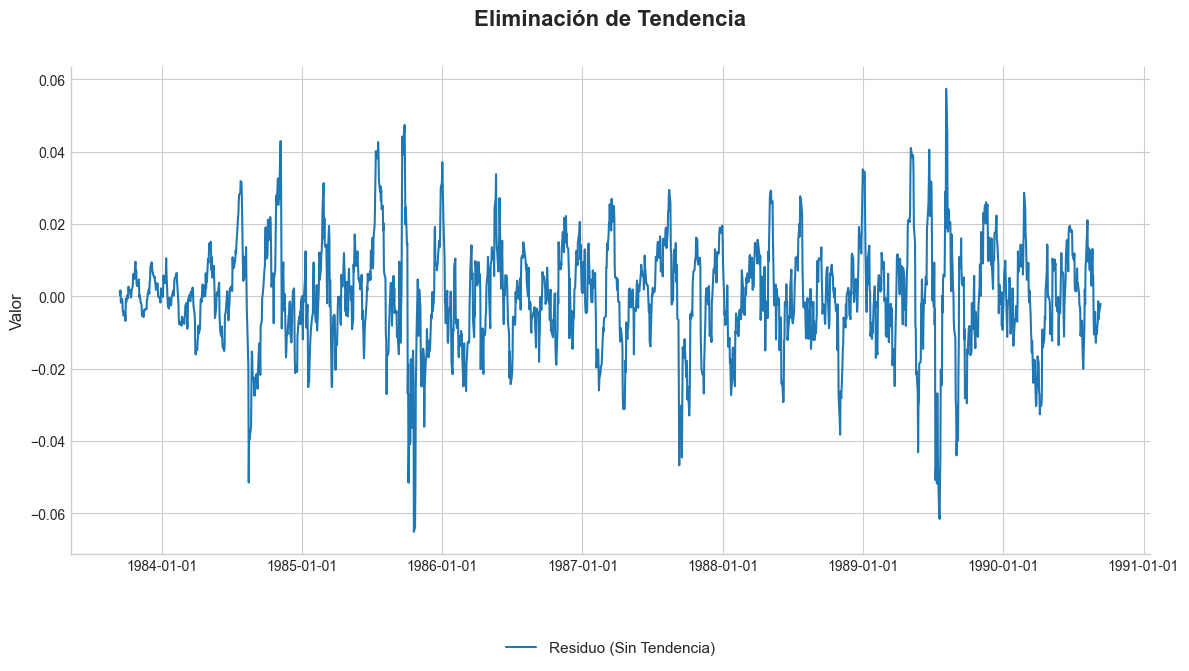

In [41]:
plot_matplotlib('Eliminación de Tendencia', 
      (df.index, df["Trend_Removed"], "Residuo (Sin Tendencia)"))

---

## 6. Análisis de Autocorrelación {#6-autocorrelacion}

### 6.1 Gráfico de Rezagos (Lag Plot)

**Objetivo:** Visualizar correlaciones a diferentes rezagos

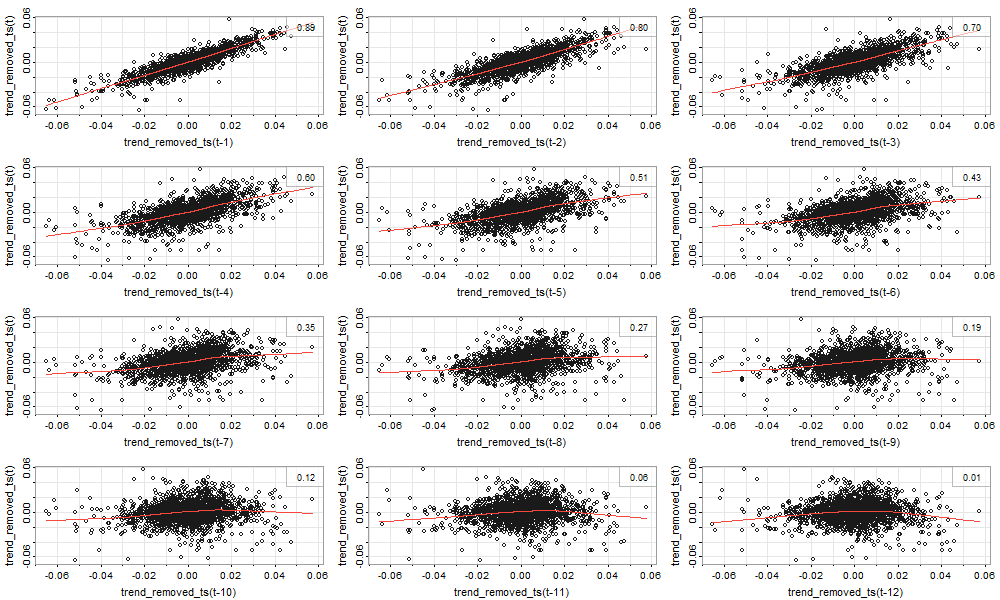

In [42]:
%%R -w 1000 -h 600
# Celda 14: Lag Plot (Primeros 12 rezagos)

library(astsa)

trend_removed_ts <- ts(df_r$Trend_Removed, frequency = 24)

options(repr.plot.width=20, repr.plot.height=6)
astsa::lag1.plot(trend_removed_ts, 12)

### 6.2 Función de Autocorrelación (ACF)

**Teoría:**
- Mide correlación entre la serie y sus rezagos
- Barras fuera de bandas → Correlación significativa
- Decaimiento lento → No estacionariedad
- Picos en 24, 48, 72... → Estacionalidad diaria


 BUSCAR:
- Picos en lag 24 - Ciclo diario
- Picos en lag 168 - Ciclo semanal
- Decaimiento rapido - Estacionariedad


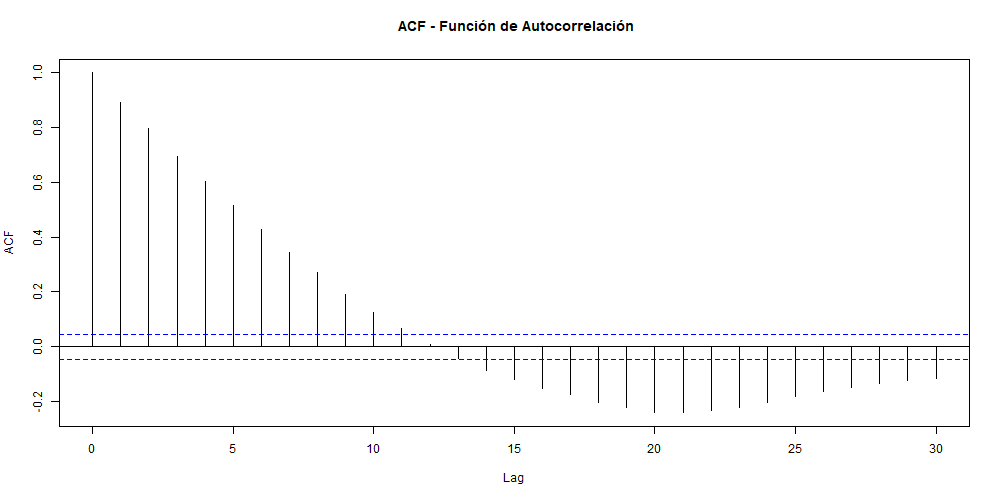

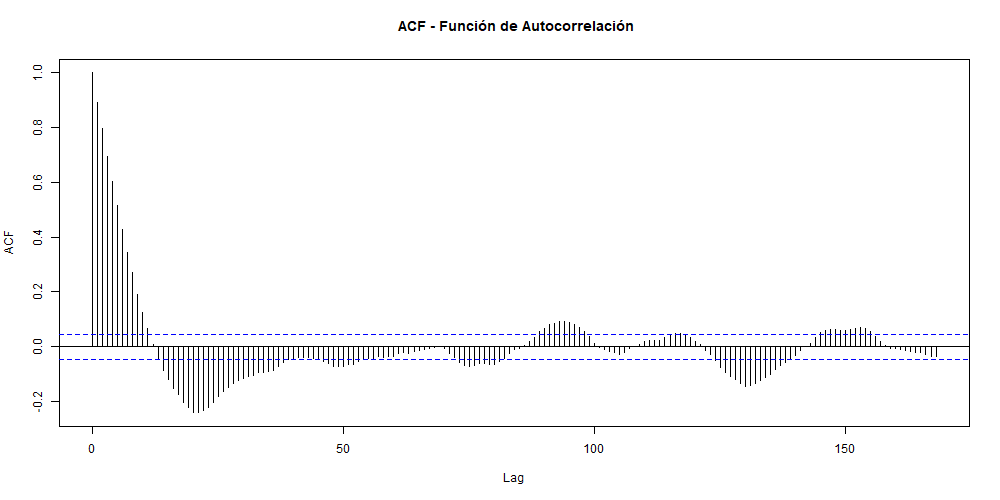

In [43]:
%%R -w 1000 -h 500
# Celda 15: ACF

acf(df_r$Trend_Removed, lag.max = 30, 
    main = " ACF - Función de Autocorrelación")


acf(df_r$Trend_Removed, lag.max = 168, 
    main = " ACF - Función de Autocorrelación")


cat("\n BUSCAR:\n")
cat("- Picos en lag 24 - Ciclo diario\n")
cat("- Picos en lag 168 - Ciclo semanal\n")
cat("- Decaimiento rapido - Estacionariedad\n")

### 6.3 Función de Autocorrelación Parcial (PACF)

**Diferencia con ACF:**
- PACF elimina efectos indirectos
- Útil para identificar orden AR en modelos ARIMA
- Corte abrupto → Indica orden del modelo

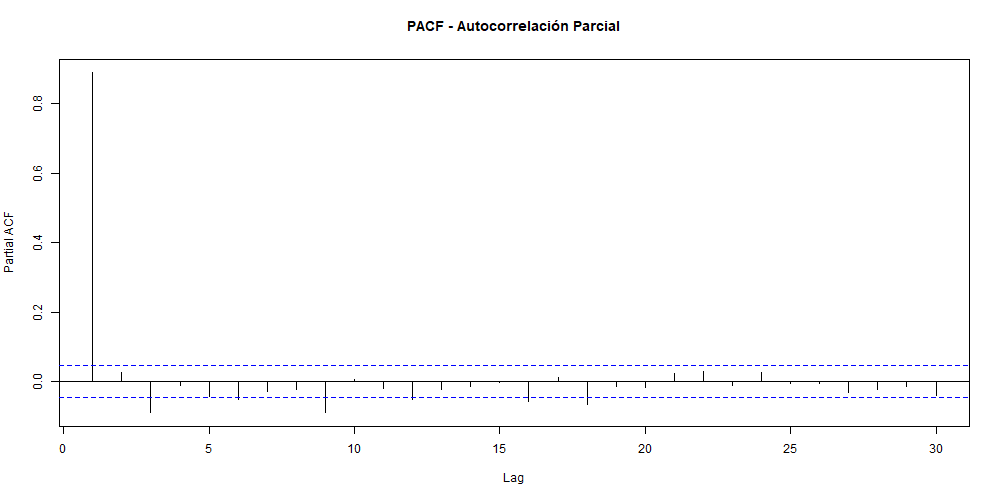

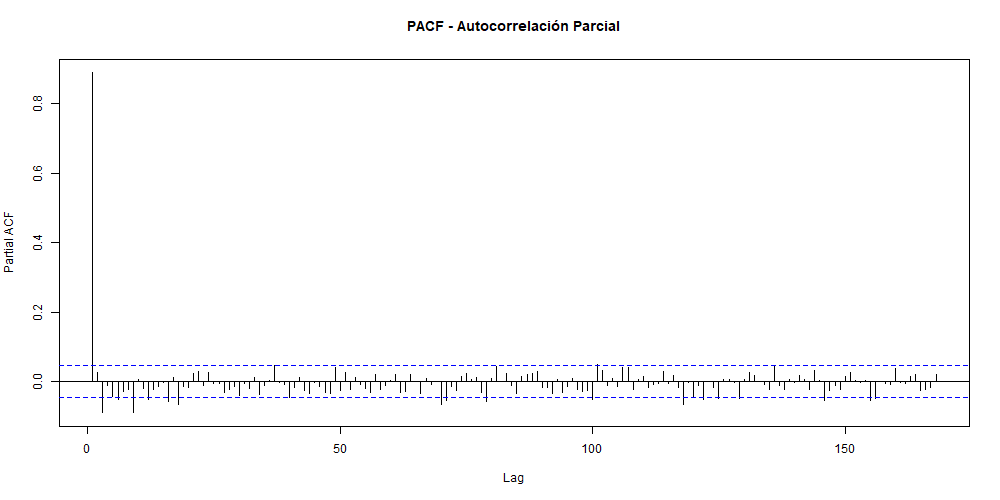

In [44]:
%%R -w 1000 -h 500
# Celda 16: PACF

pacf(df_r$Trend_Removed, lag.max = 30, 
     main = "PACF - Autocorrelación Parcial")

pacf(df_r$Trend_Removed, lag.max = 168, 
     main = "PACF - Autocorrelación Parcial")



--- Los 20 picos mas grandes (ACF) - Horizonte: 360 dias ---
                   0         1         2       3         4         5         6
Lag (dias)  1.000000 2.0000000 3.0000000 4.00000 5.0000000 6.0000000 7.0000000
Correlacion 0.890092 0.7973612 0.6952915 0.60442 0.5146348 0.4269498 0.3453507
                   7          8          9        10         11         12
Lag (dias)  8.000000 21.0000000 20.0000000 22.000000 19.0000000 23.0000000
Correlacion 0.270815 -0.2414733 -0.2389973 -0.232784 -0.2225787 -0.2221775
                    13         14        15         16         17         18
Lag (dias)  18.0000000 24.0000000 9.0000000 25.0000000 17.0000000 26.0000000
Correlacion -0.2036252 -0.2031037 0.1898528 -0.1828372 -0.1757345 -0.1628423
                     19
Lag (dias)  337.0000000
Correlacion  -0.1578621

--- Los 20 picos mas grandes (PACF) - Horizonte: 360 dias ---
                   0           1           2           3           4
Lag (dias)  1.000000  3.00000000  9.00000

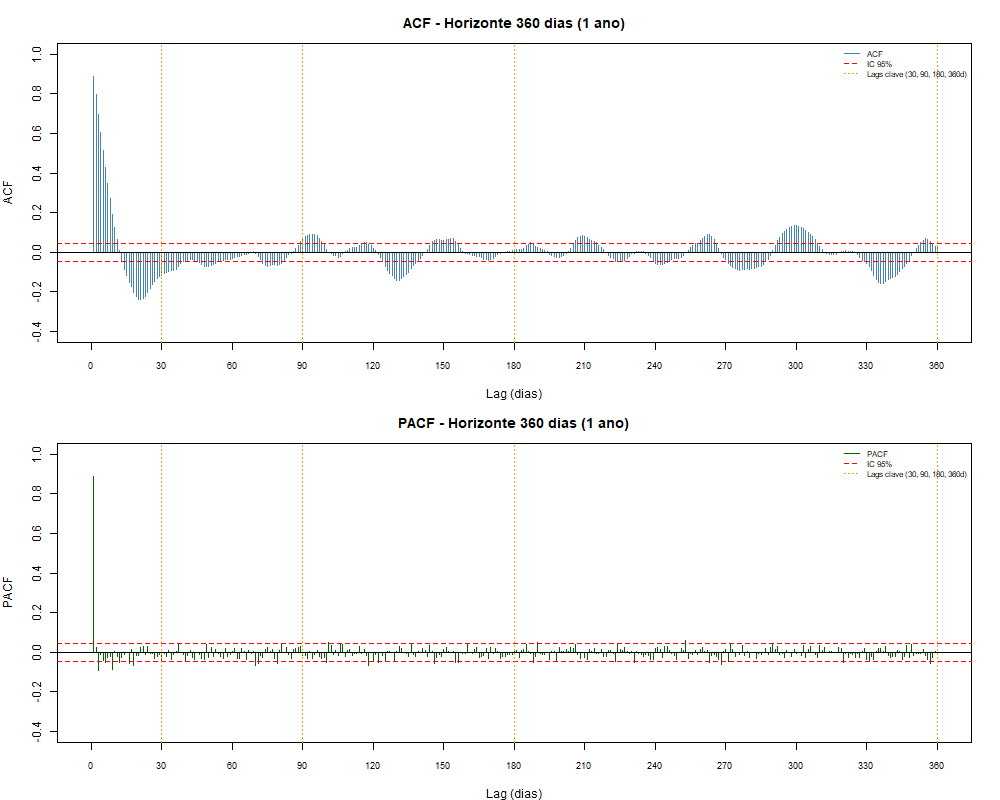

In [62]:
%%R -w 1000 -h 800

# 1. Configuracion de datos - Horizonte 360 dias (~1 año)
serie_analizar <- df_r$Trend_Removed
max_lag <- 360

# 2. Calcular ACF y PACF
acf_obj  <- acf(serie_analizar,  lag.max = max_lag, plot = FALSE)
pacf_obj <- pacf(serie_analizar, lag.max = max_lag, plot = FALSE)

# 3. Funcion para extraer picos en formato horizontal
formatear_picos_horizontal <- function(obj, n_picos = 20, es_acf = TRUE) {
  df_base <- data.frame(
    Lag   = as.numeric(obj$lag),
    Valor = as.numeric(obj$acf)
  )
  if (es_acf) df_base <- df_base[df_base$Lag > 0, ]
  
  df_top <- head(df_base[order(-abs(df_base$Valor)), ], n_picos)
  
  tabla_h <- as.data.frame(t(df_top))
  colnames(tabla_h) <- 0:(ncol(tabla_h) - 1)
  rownames(tabla_h) <- c("Lag (dias)", "Correlacion")
  return(tabla_h)
}

# 4. Generar tablas de picos
tabla_acf_final  <- formatear_picos_horizontal(acf_obj,  n_picos = 20, es_acf = TRUE)
tabla_pacf_final <- formatear_picos_horizontal(pacf_obj, n_picos = 20, es_acf = FALSE)

cat("\n--- Los 20 picos mas grandes (ACF) - Horizonte: 360 dias ---\n")
print(tabla_acf_final)
cat("\n--- Los 20 picos mas grandes (PACF) - Horizonte: 360 dias ---\n")
print(tabla_pacf_final)

# 5. Persistencia en lags clave (Mensual, Trimestral, Semestral, Anual)
cat("\n--- Persistencia en lags clave (Dias) ---\n")
lags_clave <- c(30, 90, 180, 360)
for (l in lags_clave) {
  idx <- which(round(as.numeric(acf_obj$lag), 6) == l)
  if (length(idx) > 0) {
    cat(sprintf("Lag %3d dias : %.4f\n", l, acf_obj$acf[idx]))
  }
}

# 6. Graficos
n_obs  <- length(serie_analizar)
ci_val <- qnorm(0.975) / sqrt(n_obs)

par(mfrow = c(2, 1), mar = c(4, 4, 3, 2))

# --- Gráfico ACF ---
acf_vals <- as.numeric(acf_obj$acf)
acf_lags <- as.numeric(acf_obj$lag)
acf_vals_plot <- acf_vals[acf_lags > 0]
acf_lags_plot <- acf_lags[acf_lags > 0]

plot(acf_lags_plot, acf_vals_plot,
     type = "h", col = "steelblue", lwd = 0.8,
     main = "ACF - Horizonte 360 dias (1 ano)",
     xlab = "Lag (dias)", ylab = "ACF",
     xlim = c(0, 360), ylim = c(-0.4, 1),
     xaxt = "n")
axis(1, at = seq(0, 360, by = 30),
     labels = seq(0, 360, by = 30), cex.axis = 0.75)
abline(h =  ci_val, col = "red",  lty = 2, lwd = 1.2)
abline(h = -ci_val, col = "red",  lty = 2, lwd = 1.2)
abline(h = 0,       col = "black", lwd = 0.6)
# Líneas naranjas en los lags clave
abline(v = lags_clave, col = "orange", lty = 3, lwd = 1.5)

legend("topright",
       legend = c("ACF", "IC 95%", "Lags clave (30, 90, 180, 360d)"),
       col    = c("steelblue", "red", "orange"),
       lty    = c(1, 2, 3), lwd = c(1, 1.2, 1.5),
       bty    = "n", cex = 0.7)

# --- Gráfico PACF ---
pacf_vals <- as.numeric(pacf_obj$acf)
pacf_lags <- as.numeric(pacf_obj$lag)

plot(pacf_lags, pacf_vals,
     type = "h", col = "darkgreen", lwd = 0.8,
     main = "PACF - Horizonte 360 dias (1 ano)",
     xlab = "Lag (dias)", ylab = "PACF",
     xlim = c(0, 360), ylim = c(-0.4, 1),
     xaxt = "n")
axis(1, at = seq(0, 360, by = 30),
     labels = seq(0, 360, by = 30), cex.axis = 0.75)
abline(h =  ci_val, col = "red",  lty = 2, lwd = 1.2)
abline(h = -ci_val, col = "red",  lty = 2, lwd = 1.2)
abline(h = 0,       col = "black", lwd = 0.6)
abline(v = lags_clave, col = "orange", lty = 3, lwd = 1.5)

legend("topright",
       legend = c("PACF", "IC 95%", "Lags clave (30, 90, 180, 360d)"),
       col    = c("darkgreen", "red", "orange"),
       lty    = c(1, 2, 3), lwd = c(1, 1.2, 1.5),
       bty    = "n", cex = 0.7)

par(mfrow = c(1, 1))


 DIAGNOSTICO DE RESIDUOS

[A] Test de Jarque-Bera (Normalidad):
   p-value: 0.00000
   Resultado: No Normal

[B] Test Ljung-Box (Independencia - Es ruido blanco?):
   p-value: 0.00000
   Resultado: Autocorrelacion presente

--- CONCLUSIONES ---
1. NO NORMALIDAD (Kurtosis > 3 o asimetria):
   -> Justifica uso de metricas robustas (CRPS, QuantileLoss)

2. AUTOCORRELACION RESIDUAL indica:
   - LOWESS no capturo toda la dinamica temporal
   - Modelos ARMA/LSTM manejaran esta estructura
   - Es normal en esta etapa exploratoria


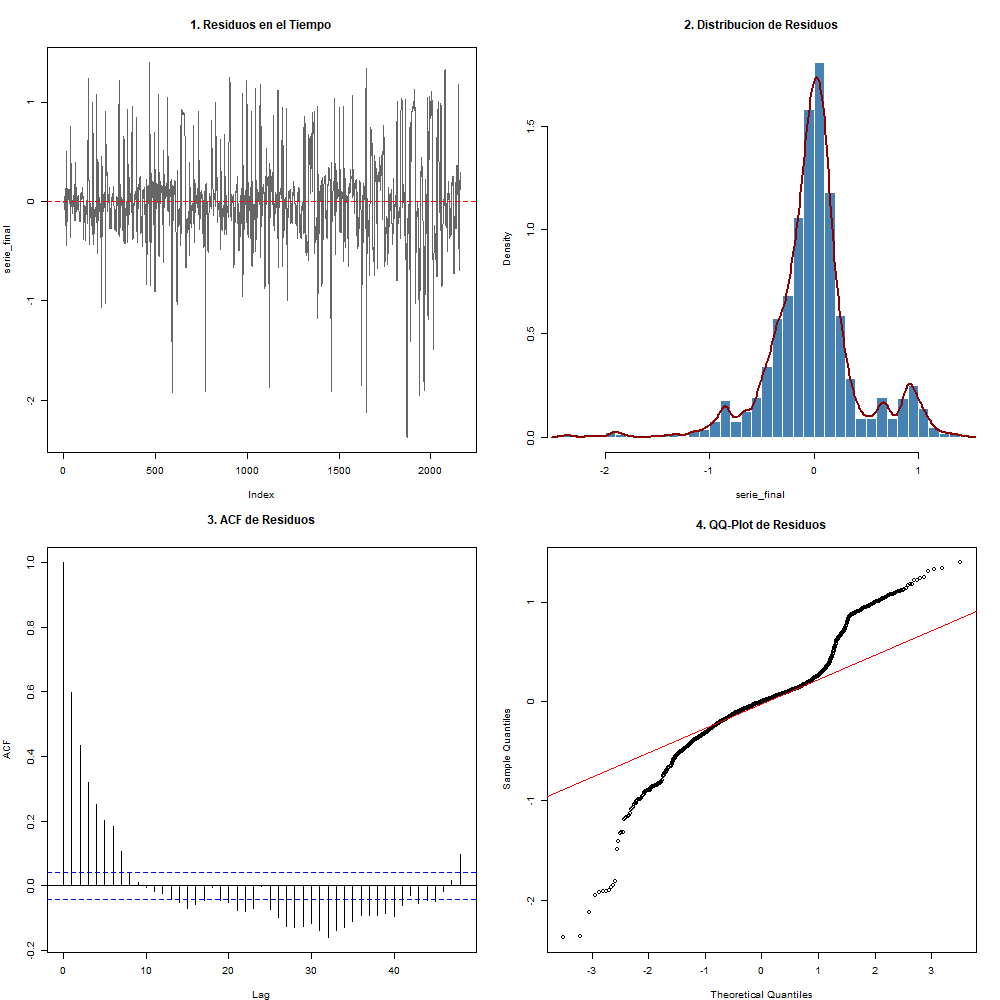

### 6.4 Información Mutua

**Ventaja:** Detecta dependencias NO LINEALES que ACF/PACF no capturan

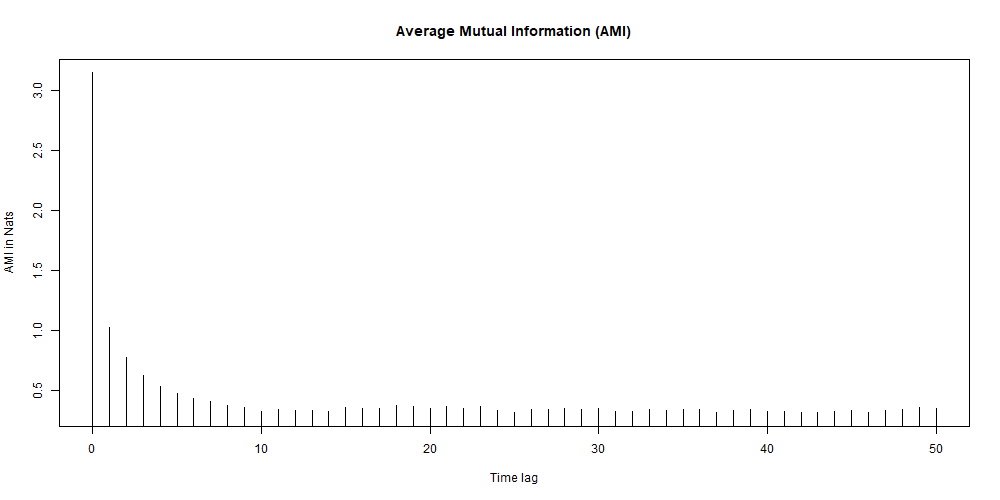

In [46]:
%%R -w 1000 -h 500
# Celda 17: Información Mutua

library(nonlinearTseries)

mi <- mutualInformation(
    df_r$Trend_Removed, 
    lag.max = 50, 
    n.partitions = 50, 
    units = "Nats", 
    do.plot = TRUE, 
    main="Información Mutua (Dependencia No Lineal)"
)

---

## 7. Tests de Estacionariedad {#7-estacionariedad}

**Estacionariedad:** Propiedades estadísticas constantes en el tiempo

**Tests complementarios:**
1. **ADF:** H₀ = No estacionaria (busca raíz unitaria)
2. **KPSS:** H₀ = Estacionaria (enfoque opuesto)

⚠️ **Buscar:** Rechazar ADF + No rechazar KPSS = Serie estacionaria

In [47]:
%%R
# Función auxiliar para interpretar p-values limpiamente
interpret_p <- function(p_val, alpha=0.05, h0_desc, h1_desc) {
    res <- ifelse(p_val < alpha, h1_desc, h0_desc)
    signif <- ifelse(p_val < 0.001, "***", ifelse(p_val < 0.01, "**", ifelse(p_val < 0.05, "*", "ns")))
    cat(sprintf("   -> p-value: %.5f (%s) \n   -> Conclusión: %s\n", p_val, signif, res))
}


 TESTS DE ESTACIONARIEDAD

[A] Augmented Dickey-Fuller (ADF)
    H0: La serie TIENE raiz unitaria (No estacionaria)
   p-value: 0.01000 (*)
   Conclusion: Se rechaza H0 (Serie Estacionaria)

[B] Kwiatkowski-Phillips-Schmidt-Shin (KPSS)
    H0: La serie ES estacionaria
   p-value: 0.10000 (ns)
   Conclusion: No se rechaza H0 (Serie Estacionaria)


In addition: Warning messages:
1: In adf.test(serie_analisis) : p-value smaller than printed p-value
2: In kpss.test(serie_analisis) : p-value greater than printed p-value


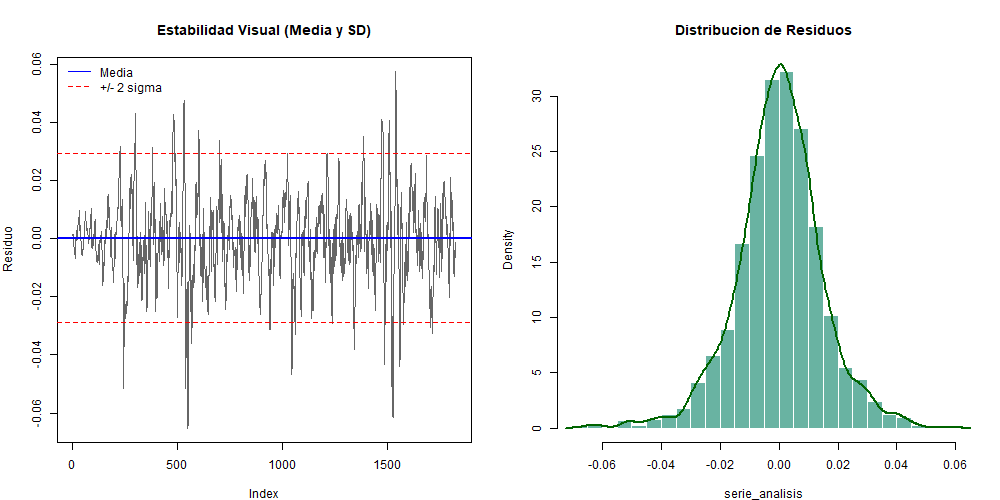

In [48]:
%%R -w 1000 -h 500
# Celda 18: Tests de Estacionariedad

library(tseries)

# Funcion auxiliar para interpretar p-values (sin acentos)
interpret_p <- function(p_val, alpha=0.05, h0_desc, h1_desc) {
    res <- ifelse(p_val < alpha, h1_desc, h0_desc)
    signif <- ifelse(p_val < 0.001, "***", 
                     if (p_val < 0.01) "**" else if (p_val < 0.05) "*" else "ns")
    cat(sprintf("   p-value: %.5f (%s)\n   Conclusion: %s\n", 
                p_val, signif, res))
}

serie_analisis <- na.omit(df_r$Trend_Removed)

# Visualizacion
par(mfrow=c(1,2), mar=c(4,4,4,2))

plot(serie_analisis, type='l', col='gray40', 
     main="Estabilidad Visual (Media y SD)", ylab="Residuo")
abline(h=mean(serie_analisis), col="blue", lwd=2)
abline(h=mean(serie_analisis) + 2*sd(serie_analisis), 
       col="red", lty=2)
abline(h=mean(serie_analisis) - 2*sd(serie_analisis), 
       col="red", lty=2)
legend("topleft", legend=c("Media", "+/- 2 sigma"), 
       col=c("blue", "red"), lty=c(1,2), bty="n")

hist(serie_analisis, breaks=40, col="#69b3a2", border="white", 
     main="Distribucion de Residuos", probability=TRUE)
lines(density(serie_analisis), col="darkgreen", lwd=2)

par(mfrow=c(1,1))

# Tests
cat("\n" , rep("=", 60), "\n", sep="")
cat(" TESTS DE ESTACIONARIEDAD\n")
cat(rep("=", 60), "\n", sep="")

# 1. ADF Test
cat("\n[A] Augmented Dickey-Fuller (ADF)\n")
cat("    H0: La serie TIENE raiz unitaria (No estacionaria)\n")
test_adf <- adf.test(serie_analisis)
interpret_p(test_adf$p.value, 0.05, 
            "No se rechaza H0 (Serie No Estacionaria)", 
            "Se rechaza H0 (Serie Estacionaria)")

# 2. KPSS Test
cat("\n[B] Kwiatkowski-Phillips-Schmidt-Shin (KPSS)\n")
cat("    H0: La serie ES estacionaria\n")
test_kpss <- kpss.test(serie_analisis)
interpret_p(test_kpss$p.value, 0.05, 
            "No se rechaza H0 (Serie Estacionaria)", 
            "Se rechaza H0 (Serie No Estacionaria)")

---

## 8. Tests de No Linealidad {#8-nolinealidad}

**¿Por qué importa?**
- Modelos lineales (ARIMA) asumen linealidad
- Si hay no linealidad → LSTM/GRU/Transformer son superiores
- Justifica métodos avanzados en tu tesis

### 8.1 Batería Completa en Python

In [49]:
# Celda 19: Tests de No Linealidad (Implementación Robusta)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.tsa.stattools import acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.linear_model import LinearRegression, Ridge
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# FUNCIONES DE TESTS
# ============================================================================

def bds_test_python(series, m=2, epsilon=None):
    """Test BDS simplificado para dependencia no lineal"""
    series = np.array(series)
    n = len(series)
    
    if epsilon is None:
        epsilon = 0.5 * np.std(series)
    
    def correlation_integral(data, eps, m):
        N = len(data) - m + 1
        vectors = np.array([data[i:i+m] for i in range(N)])
        
        count = 0
        for i in range(N):
            for j in range(i+1, N):
                if np.max(np.abs(vectors[i] - vectors[j])) < eps:
                    count += 1
        
        C_m = 2 * count / (N * (N - 1))
        return C_m if C_m > 0 else 1e-10
    
    C_1 = correlation_integral(series, epsilon, 1)
    C_m = correlation_integral(series, epsilon, m)
    V_mn = n * (C_m - C_1**m)
    sigma = np.sqrt(4 * (C_1**(2*m) + 2*sum([C_1**(2*k) for k in range(1,m)])))
    
    z_stat = V_mn / (sigma * np.sqrt(n)) if sigma > 0 else 0
    p_value = 2 * (1 - stats.norm.cdf(abs(z_stat)))
    
    return z_stat, p_value

def mcleod_li_test(series, lags=24):
    """Test McLeod-Li (Ljung-Box en residuos²)"""
    residuals = series - np.mean(series)
    squared_resid = residuals ** 2
    lb_result = acorr_ljungbox(squared_resid, lags=[lags], return_df=True)
    return lb_result

def tsay_test(series, lag=1, order=2):
    """Test de Tsay para no linealidad estructural"""
    n = len(series)
    X, y = [], []
    
    for i in range(lag * order, n):
        features = [series[i - j * lag] for j in range(1, order + 1)]
        X.append(features)
        y.append(series[i])
    
    X, y = np.array(X), np.array(y)
    
    # Regresión lineal
    model = LinearRegression()
    model.fit(X, y)
    residuals = y - model.predict(X)
    
    # Características no lineales
    X_nonlinear = []
    for i in range(len(X)):
        row = list(X[i])
        row.extend([x**2 for x in X[i]])
        for j in range(len(X[i])):
            for k in range(j+1, len(X[i])):
                row.append(X[i][j] * X[i][k])
        X_nonlinear.append(row)
    
    X_nonlinear = np.array(X_nonlinear)
    
    # Regresión de residuos²
    model_nl = Ridge(alpha=1.0)
    model_nl.fit(X_nonlinear, residuals**2)
    r2 = model_nl.score(X_nonlinear, residuals**2)
    
    n_samples = len(residuals)
    k = X_nonlinear.shape[1]
    
    if r2 < 1:
        f_stat = (r2 / k) / ((1 - r2) / (n_samples - k - 1))
        p_value = 1 - stats.f.cdf(f_stat, k, n_samples - k - 1)
    else:
        f_stat = np.inf
        p_value = 0
    
    return f_stat, p_value, r2

def hurst_exponent(series, max_lag=20):
    """Exponente de Hurst para memoria larga"""
    lags = range(2, max_lag)
    tau = []
    
    for lag in lags:
        n_subseries = len(series) // lag
        subseries = [series[i*lag:(i+1)*lag] for i in range(n_subseries)]
        
        rs_values = []
        for sub in subseries:
            if len(sub) == 0:
                continue
            mean_sub = np.mean(sub)
            cumdev = np.cumsum(sub - mean_sub)
            R = np.max(cumdev) - np.min(cumdev)
            S = np.std(sub)
            if S > 0:
                rs_values.append(R / S)
        
        if rs_values:
            tau.append(np.mean(rs_values))
        else:
            tau.append(np.nan)
    
    tau = np.array(tau)
    lags = np.array(list(lags))
    
    valid = ~np.isnan(tau) & (tau > 0)
    if sum(valid) < 2:
        return np.nan
    
    log_lags = np.log(lags[valid])
    log_tau = np.log(tau[valid])
    
    slope, intercept = np.polyfit(log_lags, log_tau, 1)
    return slope

# ============================================================================
# EJECUCIÓN DE TESTS
# ============================================================================

serie = df['Trend_Removed'].dropna().values

print("="*70)
print("   BATERÍA DE TESTS DE NO LINEALIDAD")
print("="*70)
print()

# Test 1: BDS
print("-" * 70)
print(" [1] TEST BDS (Detección de Dependencia No Lineal)")
print("-" * 70)
z_stat, p_val = bds_test_python(serie, m=2)
print(f"  Estadístico Z: {z_stat:.4f}")
print(f"  p-value: {p_val:.6f}", end="")

if p_val < 0.001:
    print(" ***")
    print("  ✓ Fuerte evidencia de dependencia no lineal")
    print("  → Justifica uso de redes neuronales sobre ARIMA")
elif p_val < 0.05:
    print(" *")
    print("  ✓ Evidencia de dependencia no lineal")
else:
    print(" (ns)")
    print("  ✗ No hay evidencia clara")
print()

# Test 2: McLeod-Li
print("-" * 70)
print(" [2] TEST McLEOD-LI (Varianza Condicional)")
print("-" * 70)
ml_result = mcleod_li_test(serie, lags=24)
lb_stat = ml_result['lb_stat'].values[0]
lb_pval = ml_result['lb_pvalue'].values[0]

print(f"  Estadístico LB: {lb_stat:.4f}")
print(f"  p-value: {lb_pval:.6f}", end="")

if lb_pval < 0.001:
    print(" ***")
    print("  ✓ Fuerte evidencia de efectos ARCH/GARCH")
    print("  → Usar predicción probabilística (cuantiles)")
elif lb_pval < 0.05:
    print(" *")
    print("  ✓ Evidencia de heterocedasticidad condicional")
else:
    print(" (ns)")
    print("  ✗ Varianza relativamente estable")
print()

# Test 3: Tsay
print("-" * 70)
print(" [3] TEST DE TSAY (No Linealidad Estructural)")
print("-" * 70)
f_stat, p_val, r2 = tsay_test(serie, lag=1, order=3)
print(f"  Estadístico F: {f_stat:.4f}")
print(f"  R² (no lineal): {r2:.4f}")
print(f"  p-value: {p_val:.6f}", end="")

if p_val < 0.001:
    print(" ***")
    print("  ✓ Fuerte no linealidad detectada")
    print("  → Modelos lineales serán insuficientes")
elif p_val < 0.05:
    print(" *")
    print("  ✓ No linealidad presente")
else:
    print(" (ns)")
    print("  ✗ Estructura lineal dominante")
print()

# Test 4: Hurst
print("-" * 70)
print(" [4] EXPONENTE DE HURST (Memoria Larga)")
print("-" * 70)
H = hurst_exponent(serie, max_lag=50)
print(f"  H = {H:.4f}")
print()
print("  Interpretación:")
if H > 0.55:
    print(f"  → Persistencia (H > 0.5): Tendencias se mantienen")
    print(f"  → Memoria larga detectada")
elif H < 0.45:
    print(f"  → Anti-persistencia (H < 0.5): Reversión a la media")
else:
    print(f"  → Random walk (H ≈ 0.5): Sin memoria significativa")
print()

print("="*70)
print("   RESUMEN PARA JUSTIFICACIÓN EN TESIS")
print("="*70)
print()
print("✓ BDS rechaza → Dependencia compleja justifica LSTM/Transformer")
print("✓ McLeod-Li rechaza → Usar CRPS sobre MSE (predicción probabilística)")
print("✓ Tsay rechaza → Modelos no lineales necesarios")
print("✓ Hurst > 0.5 → Efectos de largo plazo importantes")
print("="*70)

   BATERÍA DE TESTS DE NO LINEALIDAD

----------------------------------------------------------------------
 [1] TEST BDS (Detección de Dependencia No Lineal)
----------------------------------------------------------------------
  Estadístico Z: 4.4274
  p-value: 0.000010 ***
  ✓ Fuerte evidencia de dependencia no lineal
  → Justifica uso de redes neuronales sobre ARIMA

----------------------------------------------------------------------
 [2] TEST McLEOD-LI (Varianza Condicional)
----------------------------------------------------------------------
  Estadístico LB: 3255.9376
  p-value: 0.000000 ***
  ✓ Fuerte evidencia de efectos ARCH/GARCH
  → Usar predicción probabilística (cuantiles)

----------------------------------------------------------------------
 [3] TEST DE TSAY (No Linealidad Estructural)
----------------------------------------------------------------------
  Estadístico F: 0.3295
  R² (no lineal): 0.0016
  p-value: 0.965520 (ns)
  ✗ Estructura lineal dominante

-

### 8.2 Visualizaciones de No Linealidad

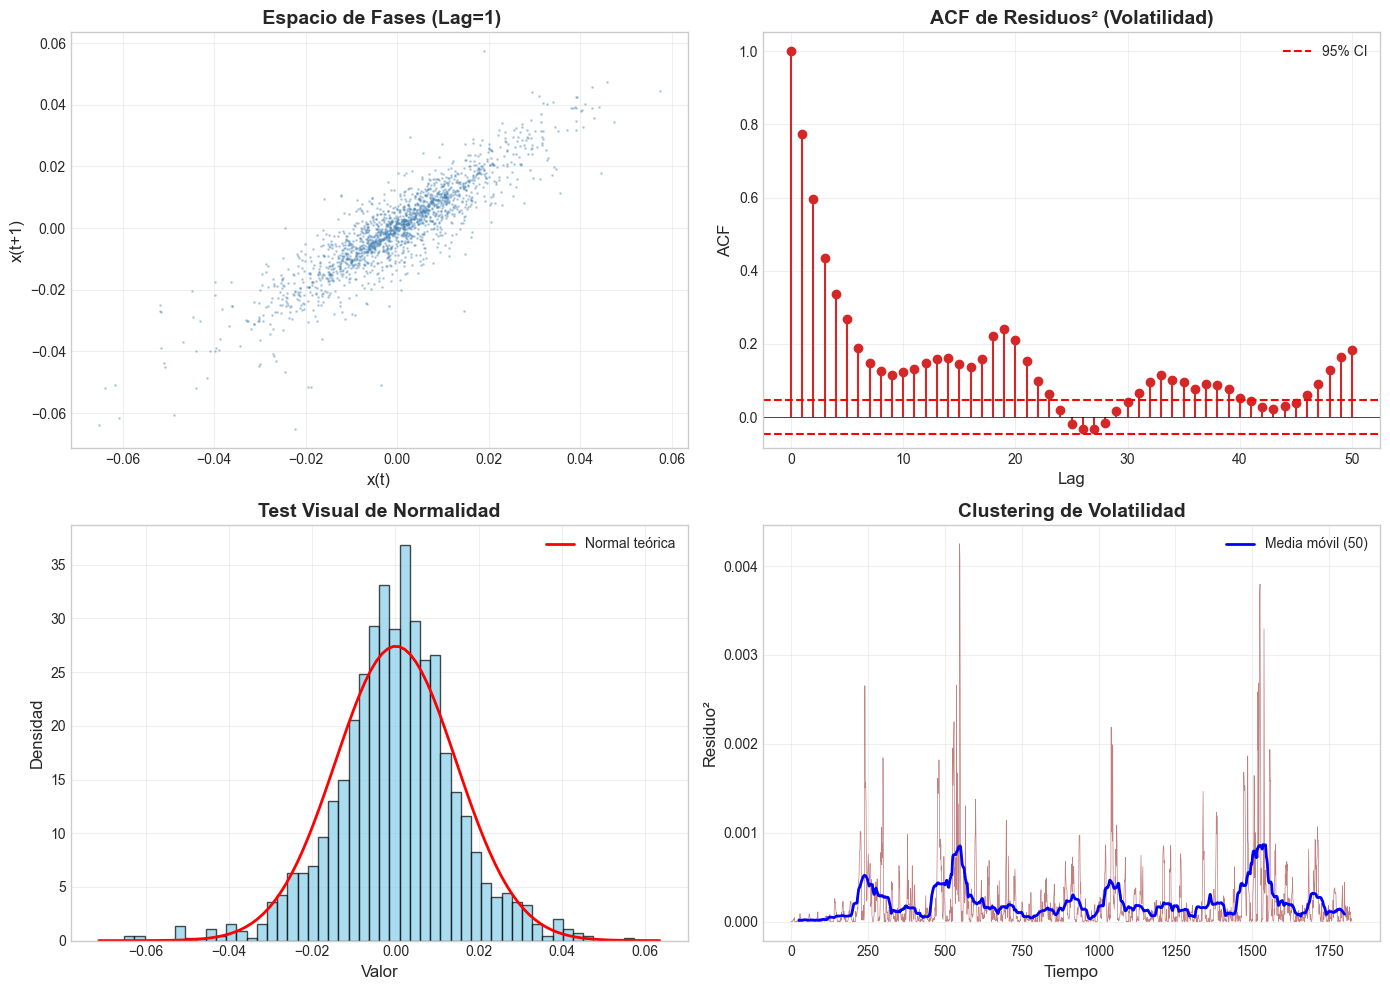

In [50]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Espacio de Fases (Atractor)
ax1 = axes[0, 0]
lag = 1
ax1.scatter(serie[:-lag], serie[lag:], alpha=0.3, s=1, c='steelblue')
ax1.set_xlabel('x(t)', fontsize=12)
ax1.set_ylabel(f'x(t+{lag})', fontsize=12)
ax1.set_title(' Espacio de Fases (Lag=1)', fontsize=14, fontweight='bold')
ax1.grid(alpha=0.3)

# 2. ACF de Residuos² (Test Visual McLeod-Li)
ax2 = axes[0, 1]
squared_acf = acf(serie**2, nlags=50)
ax2.stem(squared_acf, linefmt='C3-', markerfmt='C3o', basefmt=' ')
ax2.axhline(y=0, color='k', linestyle='-', linewidth=0.5)
ax2.axhline(y=1.96/np.sqrt(len(serie)), color='r', linestyle='--', label='95% CI')
ax2.axhline(y=-1.96/np.sqrt(len(serie)), color='r', linestyle='--')
ax2.set_title('ACF de Residuos² (Volatilidad)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Lag', fontsize=12)
ax2.set_ylabel('ACF', fontsize=12)
ax2.legend()
ax2.grid(alpha=0.3)

# 3. Distribución vs Normal
ax3 = axes[1, 0]
ax3.hist(serie, bins=50, density=True, alpha=0.7, color='skyblue', edgecolor='black')
from scipy.stats import norm
xmin, xmax = ax3.get_xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, np.mean(serie), np.std(serie))
ax3.plot(x, p, 'r-', linewidth=2, label='Normal teórica')
ax3.set_title('Test Visual de Normalidad', fontsize=14, fontweight='bold')
ax3.set_xlabel('Valor', fontsize=12)
ax3.set_ylabel('Densidad', fontsize=12)
ax3.legend()
ax3.grid(alpha=0.3)

# 4. Volatilidad (Clustering)
ax4 = axes[1, 1]
ax4.plot(serie**2, color='darkred', alpha=0.5, linewidth=0.5)
window = 50
smoothed = pd.Series(serie**2).rolling(window=window, center=True).mean()
ax4.plot(smoothed, color='blue', linewidth=2, label=f'Media móvil ({window})')
ax4.set_title('Clustering de Volatilidad', fontsize=14, fontweight='bold')
ax4.set_xlabel('Tiempo', fontsize=12)
ax4.set_ylabel('Residuo²', fontsize=12)
ax4.legend()
ax4.grid(alpha=0.3)

plt.tight_layout()
plt.show()


---

## 9. Análisis de Heterocedasticidad {#9-heterocedasticidad}

**Objetivo:** Detectar varianza condicional (efectos ARCH)

**Implicaciones:**
- Varianza cambiante en el tiempo
- Predicciones puntuales insuficientes
- Necesidad de intervalos probabilísticos


 TEST DE HETEROCEDASTICIDAD (ARCH-LM)

[ARCH-LM Test]
H0: No hay efectos ARCH (Varianza constante)

   p-value: 0.00000 (***)
   Conclusion: Heterocedastico (Varianza cambiante)

RECOMENDACION:
- Considerar modelos GARCH/EGARCH
- Usar prediccion probabilistica (cuantiles)
- CRPS como metrica principal vs MSE


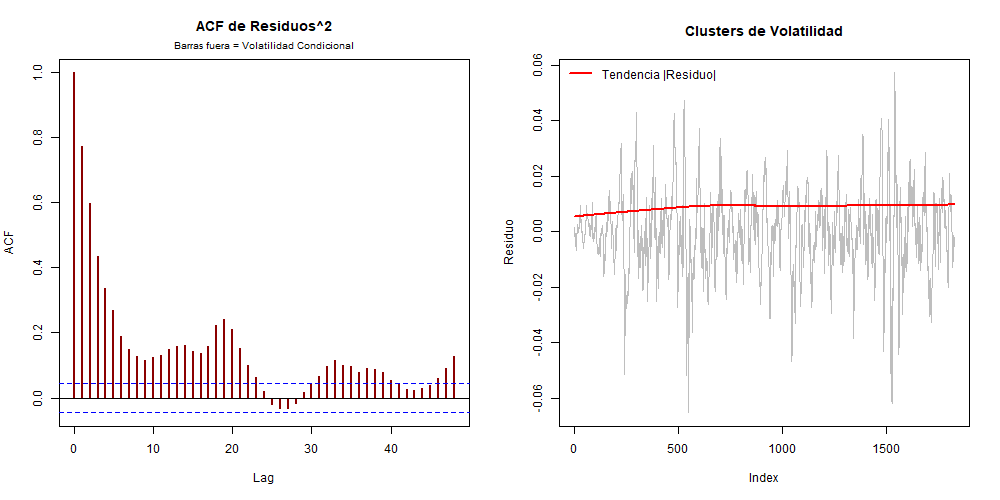

In [51]:
%%R -w 1000 -h 500
# Celda 21: Test ARCH-LM

library(FinTS)

serie_residuos <- na.omit(df_r$Trend_Removed)

par(mfrow=c(1,2))

# 1. ACF de residuos al cuadrado (Cambiado ² por ^2)
acf(serie_residuos^2, lag.max=48, 
    main="ACF de Residuos^2", col="darkred", lwd=2)
mtext("Barras fuera = Volatilidad Condicional", side=3, line=0.5, cex=0.8)

# 2. Clustering visual
plot(serie_residuos, type="l", col="gray", 
     main="Clusters de Volatilidad", ylab="Residuo")
lines(lowess(abs(serie_residuos)), col="red", lwd=2)
legend("topleft", legend="Tendencia |Residuo|", col="red", lwd=2, bty="n")

par(mfrow=c(1,1))

# Funcion auxiliar (Sin acento en Conclusion)
interpret_p <- function(p_val, alpha=0.05, h0_desc, h1_desc) {
    res <- ifelse(p_val < alpha, h1_desc, h0_desc)
    signif <- ifelse(p_val < 0.001, "***", 
                     ifelse(p_val < 0.01, "**", 
                            ifelse(p_val < 0.05, "*", "ns")))
    cat(sprintf("   p-value: %.5f (%s)\n   Conclusion: %s\n", 
                p_val, signif, res))
}

cat("\n", rep("=", 60), "\n", sep="")
cat(" TEST DE HETEROCEDASTICIDAD (ARCH-LM)\n")
cat(rep("=", 60), "\n", sep="")

cat("\n[ARCH-LM Test]\n")
cat("H0: No hay efectos ARCH (Varianza constante)\n\n") # Cambiado H0

test_arch <- ArchTest(serie_residuos, lags=24)
interpret_p(test_arch$p.value, 
            h0_desc="Homocedastico (Varianza estable)", 
            h1_desc="Heterocedastico (Varianza cambiante)") # Sin acento

if(test_arch$p.value < 0.05) {
    cat("\nRECOMENDACION:\n")
    cat("- Considerar modelos GARCH/EGARCH\n") # Cambiado viñeta
    cat("- Usar prediccion probabilistica (cuantiles)\n") # Sin acentos
    cat("- CRPS como metrica principal vs MSE\n") # Sin acento
}

---

## 10. Detección de Cambios Estructurales {#10-cambios}

**Método:** PELT (Pruned Exact Linear Time)

**Aplicaciones:**
- Detectar cambios de régimen
- Identificar eventos especiales
- Validar estabilidad del modelo



--- RESULTADOS ---
  Cambios detectados: 98 

--- Primeras 5 fechas ---
  1. Indice 24 : 1983-10-14 23:00:00
  2. Indice 37 : 1983-11-02 23:00:00
  3. Indice 53 : 1983-11-24 23:00:00
  4. Indice 110 : 1984-02-13 23:00:00
  5. Indice 128 : 1984-03-08 23:00:00

--- INTERPRETACION ---
  - Cambios pueden indicar:
    * Eventos climaticos extremos
    * Cambios en patrones de consumo
    * Intervenciones en el sistema
  - Considerar variables exogenas en estos periodos


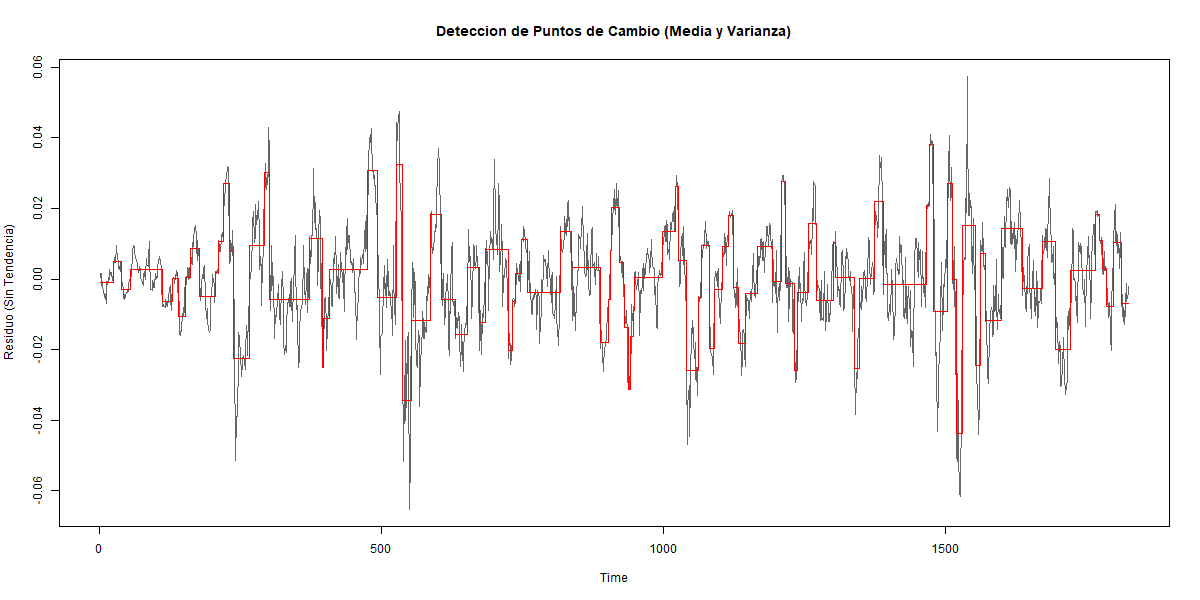

In [52]:
%%R -w 1200 -h 600
# Celda 22: Change Point Detection

library(changepoint)

# PELT con penalizacion BIC (sin acento)
# Asumiendo que df_r$Trend_Removed existe
cpt_obj <- cpt.meanvar(na.omit(df_r$Trend_Removed), 
                       method = "PELT", 
                       penalty = "BIC")

# Visualizacion
plot(cpt_obj, type = "l", col = "gray40", 
     main = "Deteccion de Puntos de Cambio (Media y Varianza)", 
     ylab = "Residuo (Sin Tendencia)")

# Extraer indices
cpts_indices <- cpts(cpt_obj)

if(length(cpts_indices) > 0) {
    cat("\n--- RESULTADOS ---\n")
    cat(paste("  Cambios detectados:", length(cpts_indices), "\n"))
    
    cat("\n--- Primeras 5 fechas ---\n")
    for(i in 1:min(5, length(cpts_indices))) {
        idx <- cpts_indices[i]
        # Aseguramos que la fecha sea string para evitar problemas de tipos
        fecha_str <- as.character(df_r$Date[idx])
        cat(sprintf("  %d. Indice %d : %s\n", 
                    i, idx, fecha_str))
    }
    
    cat("\n--- INTERPRETACION ---\n")
    cat("  - Cambios pueden indicar:\n")
    cat("    * Eventos climaticos extremos\n")
    cat("    * Cambios en patrones de consumo\n")
    cat("    * Intervenciones en el sistema\n")
    cat("  - Considerar variables exogenas en estos periodos\n")
} else {
    cat("\n--- No se detectaron cambios estructurales significativos ---\n")
    cat("   * Serie relativamente estable\n")
}

---

## 11. Diagnóstico de Residuos {#11-diagnostico}

**Objetivo:** Validar que los residuos son "ruido blanco"

**Pruebas:**
1. **Jarque-Bera:** Normalidad
2. **Ljung-Box:** Independencia (no autocorrelación)


 DIAGNOSTICO DE RESIDUOS

[A] Test de Jarque-Bera (Normalidad):
   p-value: 0.00000
   Resultado: No Normal

[B] Test Ljung-Box (Independencia - Es ruido blanco?):
   p-value: 0.00000
   Resultado: Autocorrelacion presente

--- CONCLUSIONES ---
1. NO NORMALIDAD (Kurtosis > 3 o asimetria):
   -> Justifica uso de metricas robustas (CRPS, QuantileLoss)

2. AUTOCORRELACION RESIDUAL indica:
   - LOWESS no capturo toda la dinamica temporal
   - Modelos ARMA/LSTM manejaran esta estructura
   - Es normal en esta etapa exploratoria


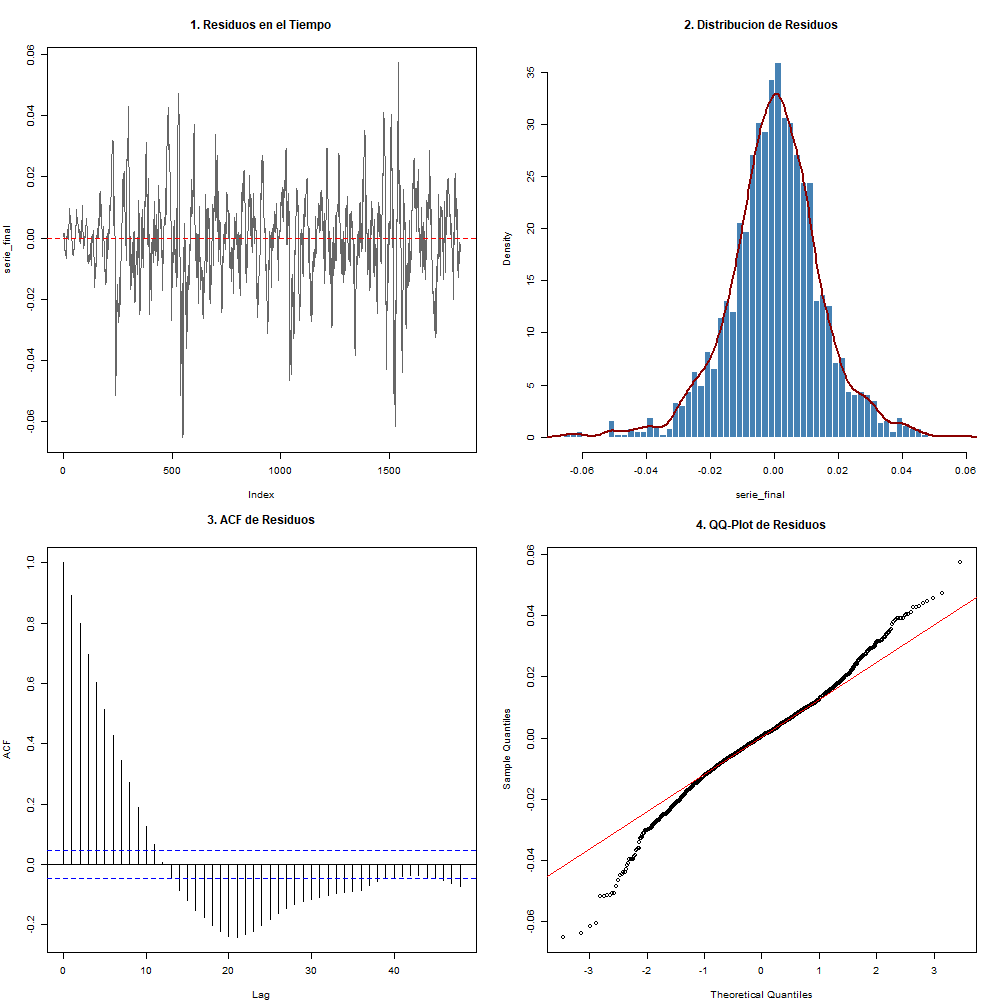

In [53]:
%%R -w 1000 -h 1000
# Celda 23: Diagnostico Completo de Residuos

library(tseries)
library(forecast)

serie_final <- na.omit(df_r$Trend_Removed)

# Panel de 2x2 para diagnostico visual
par(mfrow=c(2,2), mar=c(4,4,4,2))

# 1. Grafico de residuos
plot(serie_final, type="l", col="gray40", main="1. Residuos en el Tiempo")
abline(h=0, col="red", lty=2)

# 2. Histograma y densidad
hist(serie_final, breaks=50, border="white", col="steelblue", 
     main="2. Distribucion de Residuos", probability=TRUE)
lines(density(serie_final), col="darkred", lwd=2)

# 3. ACF (Autocorrelacion)
acf(serie_final, lag.max=48, main="3. ACF de Residuos")

# 4. QQ-Plot (Normalidad)
qqnorm(serie_final, main="4. QQ-Plot de Residuos")
qqline(serie_final, col="red")

par(mfrow=c(1,1))

# --- Tests Estadisticos ---
cat("\n", rep("=", 60), "\n", sep="")
cat(" DIAGNOSTICO DE RESIDUOS\n")
cat(rep("=", 60), "\n", sep="")

# Test de Normalidad (Jarque-Bera)
jb_test <- jarque.bera.test(serie_final)
cat("\n[A] Test de Jarque-Bera (Normalidad):\n")
cat(sprintf("   p-value: %.5f\n", jb_test$p.value))
cat(if(jb_test$p.value < 0.05) "   Resultado: No Normal\n" else "   Resultado: Normal\n")

# Test de Independencia (Ljung-Box)
lb_test <- Box.test(serie_final, lag=24, type="Ljung-Box")
cat("\n[B] Test Ljung-Box (Independencia - Es ruido blanco?):\n")
cat(sprintf("   p-value: %.5f\n", lb_test$p.value))
cat(if(lb_test$p.value < 0.05) "   Resultado: Autocorrelacion presente\n" else "   Resultado: Independientes (Ruido Blanco)\n")

cat("\n--- CONCLUSIONES ---\n")
cat("1. NO NORMALIDAD (Kurtosis > 3 o asimetria):\n")
cat("   -> Justifica uso de metricas robustas (CRPS, QuantileLoss)\n\n")

cat("2. AUTOCORRELACION RESIDUAL indica:\n")
cat("   - LOWESS no capturo toda la dinamica temporal\n")
cat("   - Modelos ARMA/LSTM manejaran esta estructura\n")
cat("   - Es normal en esta etapa exploratoria\n")

## 12. Análisis de Estacionalidad {#12-estacionalidad}

### 12.1 Box Plots por Período

In [54]:
# Celda 24: Preparación de Datos Temporales

df['Hora'] = df.index.hour
df['Dia_Semana'] = df.index.day_name()
df['Mes'] = df.index.month_name()

print("✅ Variables temporales creadas:")
print(f"  • Hora: 0-23")
print(f"  • Día: {df['Dia_Semana'].unique()}")
print(f"  • Mes: {df['Mes'].unique()}")

✅ Variables temporales creadas:
  • Hora: 0-23
  • Día: ['Tuesday' 'Wednesday' 'Thursday' 'Friday' 'Monday']
  • Mes: ['September' 'October' 'November' 'December' 'January' 'February' 'March'
 'April' 'May' 'June' 'July' 'August']


In [55]:


fig = px.box(df, x='Dia_Semana', y='BoxCox_Consumo',
             title='Estacionalidad Diaria: Perfil por Hora (Box-Cox)',
             labels={'Hora': 'Hora del Día', 'boxcox_Consumo': 'Consumo (Box-Cox)'},
             color_discrete_sequence=['#3498db'])

fig.update_layout(
    title_x=0.5,
    title_font_size=16,
    height=500
)
fig.show()


fig = px.box(df, x='Mes', y='Trend_Removed', 
             title='Estacionalidad Diaria: Perfil por Hora',
             labels={'Hora': 'Hora del Día', 'Trend_Removed': 'Residuo'},
             color_discrete_sequence=['#3498db'])

fig.update_layout(
    title_x=0.5,
    title_font_size=16,
    height=500
)
fig.show()

In [56]:
dias_orden = ["Monday", "Tuesday", "Wednesday", "Thursday", 
              "Friday", "Saturday", "Sunday"]

fig = px.box(df, x='Dia_Semana', y='Tasa',
             category_orders={"Dia_Semana": dias_orden},
             title='Estacionalidad Semanal: Perfil por Día',
             labels={'Dia_Semana': 'Día de la Semana', 'Tasa': 'Tasa'},
             color_discrete_sequence=['#e74c3c'])

fig.update_layout(
    title_x=0.5,
    title_font_size=16,
    height=500
)
fig.show()

### 12.2 Gráficos Estadísticos Avanzados (R)


--- Perfiles estacionales Semanal y Mensual generados ---


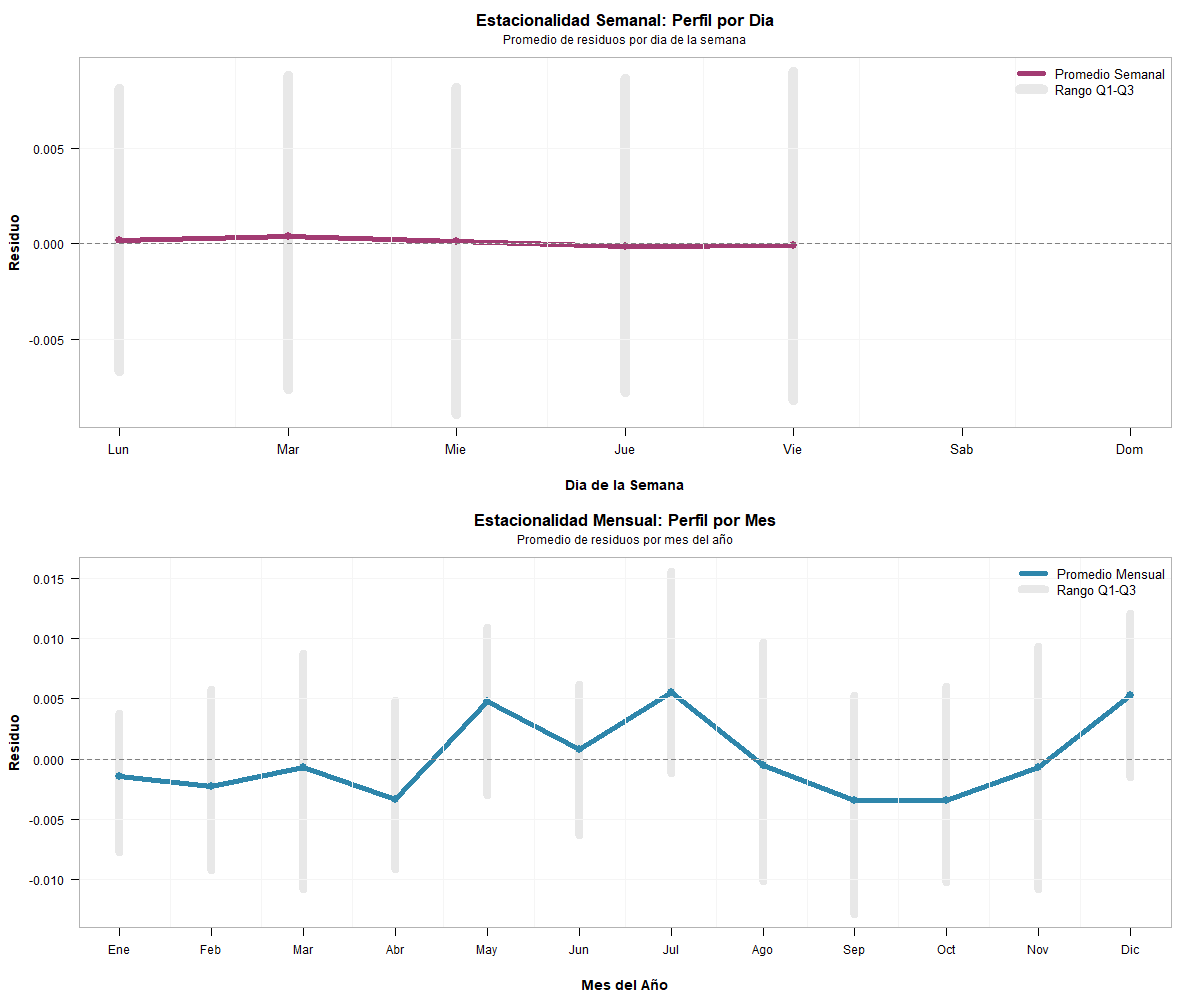

In [57]:
%%R -w 1200 -h 1000
# Celda 27: Perfiles Estacionales (Semanal y Mensual)

library(dplyr)
library(lubridate)

# Paleta de colores
col_weekly <- "#A23B72"   # Púrpura para la semana
col_monthly <- "#2E86AB"  # Azul para el mes
col_band <- "#E8E8E8"
col_grid <- "#F5F5F5"

layout(matrix(c(1, 2), nrow = 2, ncol = 1))
par(mar = c(5, 5.5, 4, 2), bg = "white", family = "sans")

# ==================================================================
# PANEL 1: ESTACIONALIDAD SEMANAL (Por dia de la semana)
# ==================================================================

weekly_stats <- df_r %>%
  mutate(Weekday = wday(Date, week_start = 1)) %>%
  group_by(Weekday) %>%
  summarise(
    Mean = mean(Trend_Removed, na.rm = TRUE),
    SD = sd(Trend_Removed, na.rm = TRUE),
    Q25 = quantile(Trend_Removed, 0.25, na.rm = TRUE),
    Q75 = quantile(Trend_Removed, 0.75, na.rm = TRUE)
  )

# Nombres de dias sin acentos
dias_semana <- c("Lun", "Mar", "Mie", "Jue", "Vie", "Sab", "Dom")

plot(weekly_stats$Weekday, weekly_stats$Mean,
     type = "n",
     xlim = c(1, 7),
     ylim = range(c(weekly_stats$Q25, weekly_stats$Q75)),
     xlab = "", ylab = "", main = "", xaxt = "n", las = 1)

# Bandas intercuartiles
for(i in 1:nrow(weekly_stats)) {
  segments(weekly_stats$Weekday[i], weekly_stats$Q25[i],
           weekly_stats$Weekday[i], weekly_stats$Q75[i],
           col = col_band, lwd = 10)
}

# Linea de media
lines(weekly_stats$Weekday, weekly_stats$Mean, 
      col = col_weekly, lwd = 5)
points(weekly_stats$Weekday, weekly_stats$Mean,
       col = col_weekly, pch = 19, cex = 1.5)

# Decoracion
axis(1, at = 1:7, labels = dias_semana, cex.axis = 1.1)
mtext("Estacionalidad Semanal: Perfil por Dia", 
      side = 3, line = 2, cex = 1.4, font = 2)
mtext("Promedio de residuos por dia de la semana", 
      side = 3, line = 0.8, cex = 1)
mtext("Dia de la Semana", side = 1, line = 3.5, cex = 1.2, font = 2)
mtext("Residuo", side = 2, line = 4, cex = 1.2, font = 2)

grid(nx = 7, ny = NULL, col = col_grid, lty = 1)
abline(h = 0, col = "gray50", lty = 2, lwd = 1.5)

legend("topright", 
       legend = c("Promedio Semanal", "Rango Q1-Q3"), 
       col = c(col_weekly, col_band), 
       lty = 1, lwd = c(5, 10), bty = "n", cex = 1.1)

box(col = "gray70", lwd = 1.5)

# ==================================================================
# PANEL 2: ESTACIONALIDAD MENSUAL (Por mes del año)
# ==================================================================

monthly_stats <- df_r %>%
  mutate(Month = month(Date)) %>%
  group_by(Month) %>%
  summarise(
    Mean = mean(Trend_Removed, na.rm = TRUE),
    SD = sd(Trend_Removed, na.rm = TRUE),
    Q25 = quantile(Trend_Removed, 0.25, na.rm = TRUE),
    Q75 = quantile(Trend_Removed, 0.75, na.rm = TRUE)
  )

# Nombres de meses sin acentos
meses_anio <- c("Ene", "Feb", "Mar", "Abr", "May", "Jun", 
                "Jul", "Ago", "Sep", "Oct", "Nov", "Dic")

plot(monthly_stats$Month, monthly_stats$Mean,
     type = "n",
     xlim = c(1, 12),
     ylim = range(c(monthly_stats$Q25, monthly_stats$Q75)),
     xlab = "", ylab = "", main = "", xaxt = "n", las = 1)

# Bandas intercuartiles
for(i in 1:nrow(monthly_stats)) {
  segments(monthly_stats$Month[i], monthly_stats$Q25[i],
           monthly_stats$Month[i], monthly_stats$Q75[i],
           col = col_band, lwd = 8)
}

# Linea de media
lines(monthly_stats$Month, monthly_stats$Mean, 
      col = col_monthly, lwd = 5)
points(monthly_stats$Month, monthly_stats$Mean,
       col = col_monthly, pch = 19, cex = 1.5)

# Decoracion
axis(1, at = 1:12, labels = meses_anio, cex.axis = 1)
mtext("Estacionalidad Mensual: Perfil por Mes", 
      side = 3, line = 2, cex = 1.4, font = 2)
mtext("Promedio de residuos por mes del año", 
      side = 3, line = 0.8, cex = 1)
mtext("Mes del Año", side = 1, line = 3.5, cex = 1.2, font = 2)
mtext("Residuo", side = 2, line = 4, cex = 1.2, font = 2)

grid(nx = 12, ny = NULL, col = col_grid, lty = 1)
abline(h = 0, col = "gray50", lty = 2, lwd = 1.5)

legend("topright", 
       legend = c("Promedio Mensual", "Rango Q1-Q3"), 
       col = c(col_monthly, col_band), 
       lty = 1, lwd = c(5, 8), bty = "n", cex = 1.1)

box(col = "gray70", lwd = 1.5)

cat("\n--- Perfiles estacionales Semanal y Mensual generados ---\n")

---

## 13. Análisis Espectral {#13-espectral}

**Objetivo:** Identificar ciclos ocultos y validar las frecuencias dominantes mediante el dominio de la frecuencia (Transformada de Fourier).

**Teoría:**
- **Periodograma:** Estima la densidad espectral de potencia. Los picos indican las frecuencias que más contribuyen a la varianza de la serie.
- **Frecuencia (f):** Ciclos por unidad de tiempo.
- **Periodo (T):** $1/f$. Si la frecuencia es $0.0416$, el periodo es $1/0.0416 \approx 24$ horas.

### 13.1 Periodograma en R

Periodo Dominante detectado: 49.3421 horas


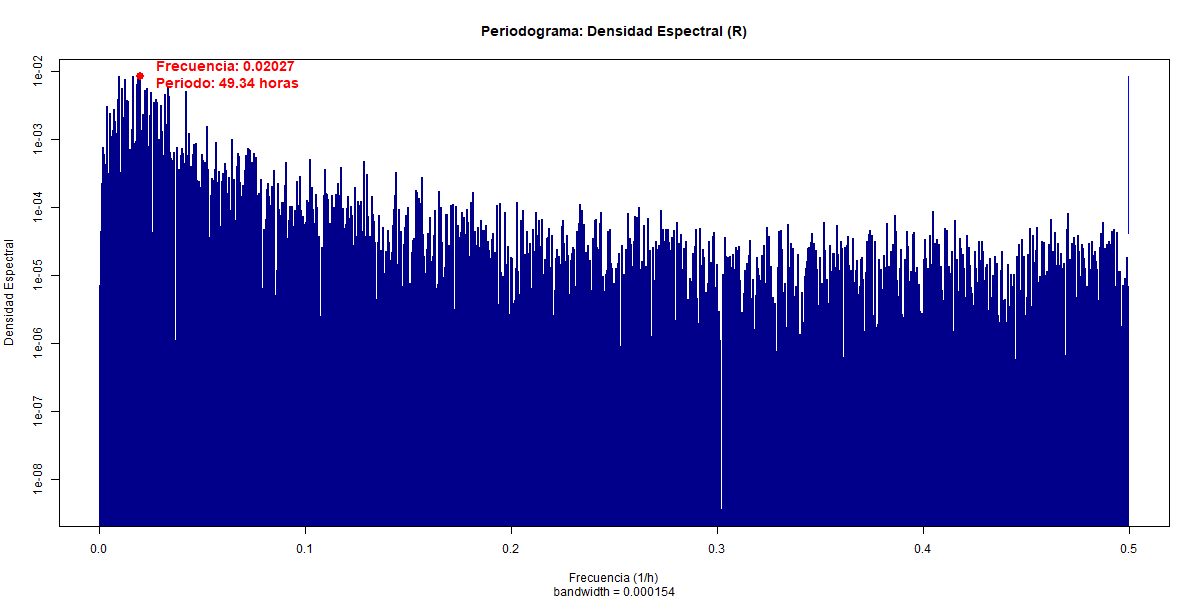

In [58]:
%%R -w 1200 -h 600
# Celda 28: Periodograma Raw

# 1. Preparar datos (quitamos NAs)
clean_data <- na.omit(df_r$Trend_Removed)

# 2. Calcular el periodograma
Periogram <- spectrum(as.numeric(clean_data), log = 'no', plot = FALSE)

# 3. Encontrar el pico maximo
ubicacion <- which.max(Periogram$spec)
max_freq <- Periogram$freq[ubicacion]
max_spec <- Periogram$spec[ubicacion]
max_period <- 1 / max_freq

# 4. Graficar
plot(Periogram, 
     main = "Periodograma: Densidad Espectral (R)",
     xlab = "Frecuencia (1/h)", ylab = "Densidad Espectral",
     col = "darkblue", lwd = 2, type="h")

# Marcamos el punto maximo
points(max_freq, max_spec, col = "red", pch = 19, cex = 1.5)

text(max_freq, max_spec, 
     sprintf("  Frecuencia: %.5f\n  Periodo: %.2f horas", max_freq, max_period), 
     pos = 4, col = "red", cex = 1.2, font = 2)

cat("Periodo Dominante detectado:", round(max_period, 4), "horas\n")

### 13.2 Análisis Multiespectral en Python (Welch)

**Ventaja:** El método de Welch suaviza el ruido del periodograma clásico dividiendo la serie en segmentos, lo que permite una estimación más robusta de las frecuencias.

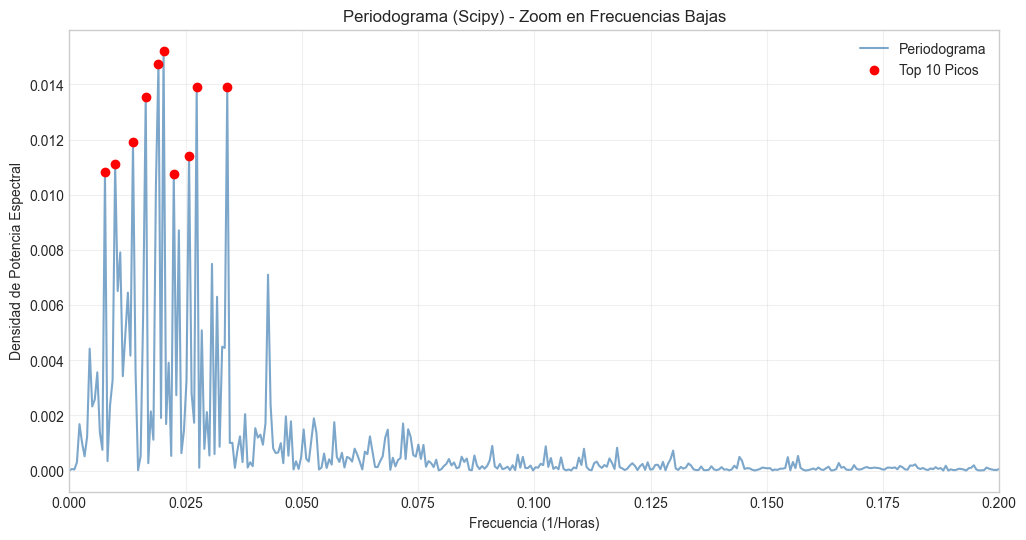

--- Los 10 Picos más grandes (Periodograma) ---


,0,1,2,3,4,5,6,7,8,9
Frecuencia,0.020274,0.019178,0.027397,0.033973,0.016438,0.013699,0.025753,0.009863,0.007671,0.022466
Periodo (Horas),49.324324,52.142857,36.500000,29.435484,60.833333,73.000000,38.829787,101.388889,130.357143,44.512195
Densidad Potencia,0.015230,0.014748,0.013910,0.013907,0.013564,0.011898,0.011409,0.011102,0.010843,0.010772


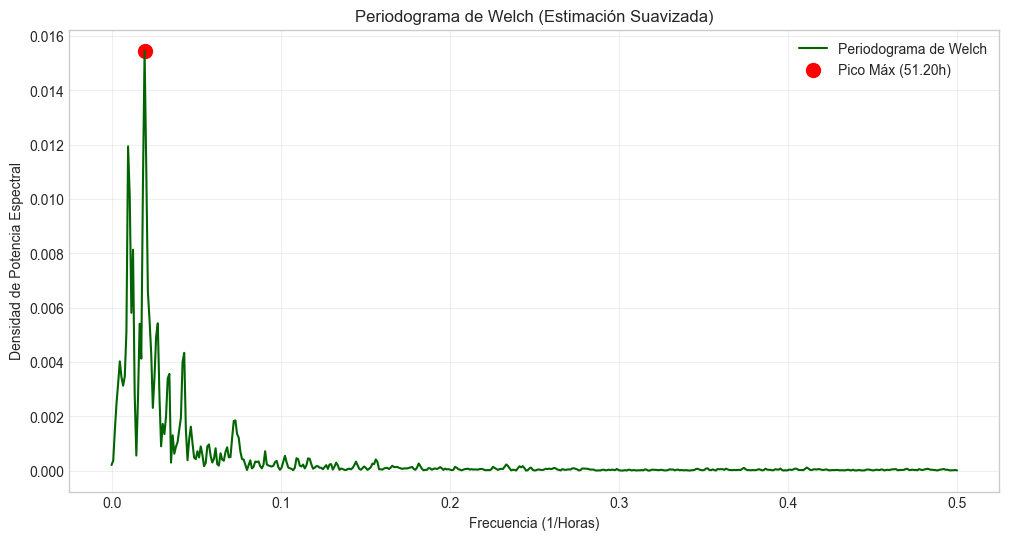


RESULTADO WELCH:
--------------------------------------------
El pico más notorio se da: 
 - Frecuencia: 0.01953 Hz (ciclos/hora)
 - Periodo:    51.20 Horas
 - Densidad:   0.02
--------------------------------------------



In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.signal as signal
import heapq

# 1. Preparar datos (Eliminar NAs es crucial para FFT)
trend_removed = df['Trend_Removed'].dropna()

# ==========================================
# A. PERIODOGRAMA ESTÁNDAR
# ==========================================

# Calcular el periodograma
f, Pxx_den = signal.periodogram(trend_removed)

# Encontrar los 10 picos más importantes
# Usamos heapq para buscar los índices de los valores más altos
peaks_indices = heapq.nlargest(10, range(len(Pxx_den)), key=Pxx_den.__getitem__)

f_freq = f[peaks_indices]
densidad = Pxx_den[peaks_indices]

# Evitar división por cero si la frecuencia 0 (DC) es seleccionada
with np.errstate(divide='ignore'):
    f_period = 1 / f_freq

# Graficar el periodograma estándar
plt.figure(figsize=(12, 6))
plt.plot(f, Pxx_den, label='Periodograma', color='steelblue', alpha=0.7)
plt.scatter(f[peaks_indices], Pxx_den[peaks_indices], color='red', zorder=5, label='Top 10 Picos')

# Zoom opcional: limitamos X para ver mejor las frecuencias bajas (donde están los ciclos de 24h y 168h)
plt.xlim(0, 0.2) 

plt.xlabel('Frecuencia (1/Horas)')
plt.ylabel('Densidad de Potencia Espectral')
plt.title('Periodograma (Scipy) - Zoom en Frecuencias Bajas')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print('--- Los 10 Picos más grandes (Periodograma) ---')

# Crear DataFrame con resultados
data = {
    'Frecuencia': f_freq, 
    'Periodo (Horas)': f_period, 
    'Densidad Potencia': densidad
}
df_frecuencias_periodos = pd.DataFrame(data).sort_values(by='Densidad Potencia', ascending=False)

# Mostrar tabla traspuesta para fácil lectura
display(df_frecuencias_periodos.T)


# ==========================================
# B. PERIODOGRAMA DE WELCH (Más suave)
# ==========================================

# Calcular Welch (nperseg define la resolución, 1024 es bueno para hourly)
f_welch, Pxx_den_welch = signal.welch(trend_removed, nperseg=1024)

# Encontrar el pico más alto
max_index_value_welch = np.argmax(Pxx_den_welch)
frecuencia_max_welch = f_welch[max_index_value_welch]
frecuencia_pico_welch = 1 / frecuencia_max_welch
max_densidad_welch = Pxx_den_welch[max_index_value_welch]

# Graficar Welch
plt.figure(figsize=(12, 6))
plt.plot(f_welch, Pxx_den_welch, label='Periodograma de Welch', color='darkgreen')
plt.scatter(frecuencia_max_welch, max_densidad_welch, color='red', s=100, label=f'Pico Máx ({frecuencia_pico_welch:.2f}h)')

plt.xlabel('Frecuencia (1/Horas)')
plt.ylabel('Densidad de Potencia Espectral')
plt.title('Periodograma de Welch (Estimación Suavizada)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"""
RESULTADO WELCH:
--------------------------------------------
El pico más notorio se da: 
 - Frecuencia: {frecuencia_max_welch:.5f} Hz (ciclos/hora)
 - Periodo:    {frecuencia_pico_welch:.2f} Horas
 - Densidad:   {max_densidad_welch:.2f}
--------------------------------------------
""")